In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
1_3_5


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5518 - accuracy: 0.6581 - precision: 0.9518 - recall: 0.6420 - f1: 0.7524 - specificity: 0.7608 - negative_predictive_value: 0.2486 - matthews_correlation_coefficient: 0.2857 - val_loss: 0.5626 - val_accuracy: 0.6305 - val_precision: 0.9805 - val_recall: 0.5930 - val_f1: 0.7333 - val_specificity: 0.9002 - val_negative_predictive_value: 0.2600 - val_matthews_correlation_coefficient: 0.3376

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33759, saving model to ../models/autoencoders_requirements/blurred_2020_03_23-23_04_35.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4917 - accuracy: 0.6594 - precision: 0.9640 - recall: 0.6331 - f1: 0.7556 - specificity: 0.8443 - negative_predictive_value: 0.2778 - matthews_correlation_coefficient: 0.3338 - val_loss: 0.4888 - val_accuracy: 0.7372 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.40433
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4280 - accuracy: 0.7373 - precision: 0.9710 - recall: 0.7189 - f1: 0.8222 - specificity: 0.8533 - negative_predictive_value: 0.3323 - matthews_correlation_coefficient: 0.4103 - val_loss: 0.4670 - val_accuracy: 0.7736 - val_precision: 0.9588 - val_recall: 0.7767 - val_f1: 0.8553 - val_specificity: 0.7688 - val_negative_predictive_value: 0.3512 - val_matthews_correlation_coefficient: 0.4042

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.40433
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4223 - accuracy: 0.7551 - precision: 0.9706 - recall: 0.7397 - f1: 0.8338 - specificity: 0.8327 - negative_predictive_value: 0.3647 - matthews_correlation_coefficient: 0.4331 - val_loss: 0.4138 - val_accuracy: 0.7997 - val_precision: 0.9442 - val_recall: 0.8221 - val_f1: 0.8764 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3989 - accuracy: 0.7727 - precision: 0.9682 - recall: 0.7612 - f1: 0.8481 - specificity: 0.8397 - negative_predictive_value: 0.3717 - matthews_correlation_coefficient: 0.4485 - val_loss: 0.5012 - val_accuracy: 0.7190 - val_precision: 0.9754 - val_recall: 0.6980 - val_f1: 0.8097 - val_specificity: 0.8573 - val_negative_predictive_value: 0.3106 - val_matthews_correlation_coefficient: 0.3917

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.45109
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4164 - accuracy: 0.7471 - precision: 0.9749 - recall: 0.7263 - f1: 0.8267 - specificity: 0.8680 - negative_predictive_value: 0.3507 - matthews_correlation_coefficient: 0.4342 - val_loss: 0.3788 - val_accuracy: 0.8031 - val_precision: 0.9657 - val_recall: 0.8050 - val_f1: 0.8754 - val_specificity: 0.8005 - val_negative_predictive_value: 0.3949 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.46083
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3932 - accuracy: 0.7685 - precision: 0.9720 - recall: 0.7516 - f1: 0.8442 - specificity: 0.8559 - negative_predictive_value: 0.3690 - matthews_correlation_coefficient: 0.4504 - val_loss: 0.3502 - val_accuracy: 0.8222 - val_precision: 0.9608 - val_recall: 0.8322 - val_f1: 0.8898 - val_specificity: 0.7525 - val_negative_predictive_value: 0.4098 - val_matthews_correlation_coefficient: 0.4593

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.46083
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3863 - accuracy: 0.7898 - precision: 0.9704 - recall: 0.7794 - f1: 0.8603 - specificity: 0.8717 - negative_predictive_value: 0.3972 - matthews_correlation_coefficient: 0.4847 - val_loss: 0.3809 - val_accuracy: 0.8153 - val_precision: 0.9651 - val_recall: 0.8196 - val_f1: 0.8844 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3732 - accuracy: 0.7892 - precision: 0.9711 - recall: 0.7784 - f1: 0.8602 - specificity: 0.8790 - negative_predictive_value: 0.3973 - matthews_correlation_coefficient: 0.4870 - val_loss: 0.4562 - val_accuracy: 0.7641 - val_precision: 0.9733 - val_recall: 0.7527 - val_f1: 0.8457 - val_specificity: 0.8384 - val_negative_predictive_value: 0.3514 - val_matthews_correlation_coefficient: 0.4315

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.49722
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3810 - accuracy: 0.7870 - precision: 0.9730 - recall: 0.7717 - f1: 0.8570 - specificity: 0.8579 - negative_predictive_value: 0.3878 - matthews_correlation_coefficient: 0.4709 - val_loss: 0.3872 - val_accuracy: 0.8014 - val_precision: 0.9700 - val_recall: 0.7988 - val_f1: 0.8735 - val_specificity: 0.8148 - val_negative_predictive_value: 0.3927 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3579 - accuracy: 0.8030 - precision: 0.9738 - recall: 0.7909 - f1: 0.8689 - specificity: 0.8757 - negative_predictive_value: 0.4147 - matthews_correlation_coefficient: 0.5043 - val_loss: 0.4249 - val_accuracy: 0.7754 - val_precision: 0.9626 - val_recall: 0.7738 - val_f1: 0.8552 - val_specificity: 0.7837 - val_negative_predictive_value: 0.3562 - val_matthews_correlation_coefficient: 0.4153

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.49722
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3841 - accuracy: 0.7839 - precision: 0.9772 - recall: 0.7686 - f1: 0.8561 - specificity: 0.8810 - negative_predictive_value: 0.3936 - matthews_correlation_coefficient: 0.4830 - val_loss: 0.3977 - val_accuracy: 0.8127 - val_precision: 0.9588 - val_recall: 0.8226 - val_f1: 0.8834 - val_specificity: 0.7493 - val_negative_predictive_value: 0.3994 - val_matthews_correlation_coefficie

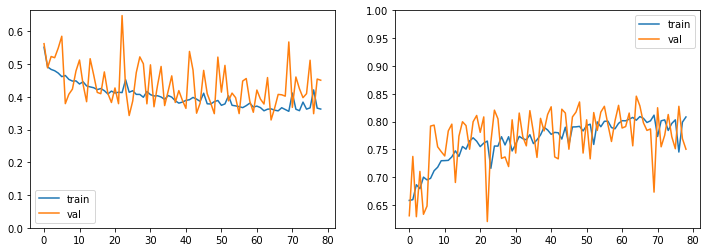

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6734 - accuracy: 0.6024 - precision: 0.7448 - recall: 0.6230 - f1: 0.6625 - specificity: 0.5641 - negative_predictive_value: 0.4282 - matthews_correlation_coefficient: 0.1865 - val_loss: 0.6522 - val_accuracy: 0.6453 - val_precision: 0.7519 - val_recall: 0.7203 - val_f1: 0.7291 - val_specificity: 0.5078 - val_negative_predictive_value: 0.4706 - val_matthews_correlation_coefficient: 0.2239

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.22391, saving model to ../models/autoencoders_requirements/looking_away_2020_03_23-23_16_25.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6658 - accuracy: 0.6245 - precision: 0.7564 - recall: 0.6515 - f1: 0.6873 - specificity: 0.5699 - negative_predictive_value: 0.4646 - matthews_correlation_coefficient: 0.2217 - val_loss: 0.7197 - val_accuracy: 0.5464 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6215 - accuracy: 0.6681 - precision: 0.7902 - recall: 0.6871 - f1: 0.7271 - specificity: 0.6274 - negative_predictive_value: 0.5052 - matthews_correlation_coefficient: 0.3054 - val_loss: 0.6201 - val_accuracy: 0.6652 - val_precision: 0.7715 - val_recall: 0.6570 - val_f1: 0.7036 - val_specificity: 0.6380 - val_negative_predictive_value: 0.4943 - val_matthews_correlation_coefficient: 0.3059

Epoch 00015: val_matthews_correlation_coefficient improved from 0.29297 to 0.30592, saving model to ../models/autoencoders_requirements/looking_away_2020_03_23-23_16_25.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6067 - accuracy: 0.6790 - precision: 0.7988 - recall: 0.6925 - f1: 0.7367 - specificity: 0.6476 - negative_predictive_value: 0.5162 - matthews_correlation_coefficient: 0.3280 - val_loss: 0.6137 - val_accuracy: 0.6453 - val_precision: 0.7828 - val_recall: 0.6656 - val_f1: 0.7123 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5797 - accuracy: 0.6931 - precision: 0.8086 - recall: 0.7138 - f1: 0.7525 - specificity: 0.6584 - negative_predictive_value: 0.5360 - matthews_correlation_coefficient: 0.3573 - val_loss: 0.5650 - val_accuracy: 0.7311 - val_precision: 0.7731 - val_recall: 0.8636 - val_f1: 0.8119 - val_specificity: 0.4757 - val_negative_predictive_value: 0.6128 - val_matthews_correlation_coefficient: 0.3597

Epoch 00029: val_matthews_correlation_coefficient improved from 0.34096 to 0.35967, saving model to ../models/autoencoders_requirements/looking_away_2020_03_23-23_16_25.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5801 - accuracy: 0.6993 - precision: 0.8112 - recall: 0.7223 - f1: 0.7587 - specificity: 0.6600 - negative_predictive_value: 0.5408 - matthews_correlation_coefficient: 0.3660 - val_loss: 0.6151 - val_accuracy: 0.6774 - val_precision: 0.7656 - val_recall: 0.7645 - val_f1: 0.7592 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.35967
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5679 - accuracy: 0.6970 - precision: 0.8175 - recall: 0.7057 - f1: 0.7513 - specificity: 0.6912 - negative_predictive_value: 0.5474 - matthews_correlation_coefficient: 0.3794 - val_loss: 0.6276 - val_accuracy: 0.6635 - val_precision: 0.7790 - val_recall: 0.7100 - val_f1: 0.7370 - val_specificity: 0.5766 - val_negative_predictive_value: 0.4915 - val_matthews_correlation_coefficient: 0.2772

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.35967
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5685 - accuracy: 0.6952 - precision: 0.8152 - recall: 0.7024 - f1: 0.7464 - specificity: 0.6836 - negative_predictive_value: 0.5386 - matthews_correlation_coefficient: 0.3702 - val_loss: 0.6004 - val_accuracy: 0.6765 - val_precision: 0.8198 - val_recall: 0.6778 - val_f1: 0.7340 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5491 - accuracy: 0.7124 - precision: 0.8307 - recall: 0.7190 - f1: 0.7658 - specificity: 0.7104 - negative_predictive_value: 0.5612 - matthews_correlation_coefficient: 0.4091 - val_loss: 0.5849 - val_accuracy: 0.6912 - val_precision: 0.8037 - val_recall: 0.7255 - val_f1: 0.7568 - val_specificity: 0.6302 - val_negative_predictive_value: 0.5243 - val_matthews_correlation_coefficient: 0.3404

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.36860
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5503 - accuracy: 0.7056 - precision: 0.8263 - recall: 0.7061 - f1: 0.7554 - specificity: 0.6943 - negative_predictive_value: 0.5496 - matthews_correlation_coefficient: 0.3888 - val_loss: 0.5606 - val_accuracy: 0.7225 - val_precision: 0.8006 - val_recall: 0.7954 - val_f1: 0.7926 - val_specificity: 0.5833 - val_negative_predictive_value: 0.5756 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.37600
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5461 - accuracy: 0.7104 - precision: 0.8286 - recall: 0.7216 - f1: 0.7641 - specificity: 0.7009 - negative_predictive_value: 0.5614 - matthews_correlation_coefficient: 0.4049 - val_loss: 0.5673 - val_accuracy: 0.7173 - val_precision: 0.8235 - val_recall: 0.7528 - val_f1: 0.7793 - val_specificity: 0.6551 - val_negative_predictive_value: 0.5577 - val_matthews_correlation_coefficient: 0.3928

Epoch 00073: val_matthews_correlation_coefficient improved from 0.37600 to 0.39281, saving model to ../models/autoencoders_requirements/looking_away_2020_03_23-23_16_25.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5512 - accuracy: 0.7030 - precision: 0.8155 - recall: 0.7089 - f1: 0.7516 - specificity: 0.6809 - negative_predictive_value: 0.5473 - matthews_correlation_coefficient: 0.3752 - val_loss: 0.6106 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5394 - accuracy: 0.7108 - precision: 0.8245 - recall: 0.7098 - f1: 0.7566 - specificity: 0.7109 - negative_predictive_value: 0.5593 - matthews_correlation_coefficient: 0.4026 - val_loss: 0.6234 - val_accuracy: 0.6687 - val_precision: 0.8351 - val_recall: 0.6457 - val_f1: 0.7205 - val_specificity: 0.7167 - val_negative_predictive_value: 0.4943 - val_matthews_correlation_coefficient: 0.3443

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.40934
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5354 - accuracy: 0.7130 - precision: 0.8291 - recall: 0.7071 - f1: 0.7572 - specificity: 0.7225 - negative_predictive_value: 0.5617 - matthews_correlation_coefficient: 0.4079 - val_loss: 0.6801 - val_accuracy: 0.6392 - val_precision: 0.8634 - val_recall: 0.5628 - val_f1: 0.6721 - val_specificity: 0.7931 - val_negative_predictive_value: 0.4668 - val_matthews_correlation_coefficie

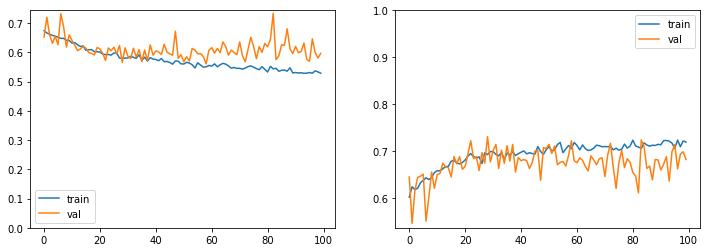

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6333 - accuracy: 0.6471 - precision: 0.6442 - recall: 0.6551 - f1: 0.6202 - specificity: 0.6314 - negative_predictive_value: 0.6673 - matthews_correlation_coefficient: 0.3039 - val_loss: 0.5812 - val_accuracy: 0.6895 - val_precision: 0.6651 - val_recall: 0.6814 - val_f1: 0.6666 - val_specificity: 0.6883 - val_negative_predictive_value: 0.6979 - val_matthews_correlation_coefficient: 0.3661

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.36611, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_23-23_31_28.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6020 - accuracy: 0.6826 - precision: 0.6759 - recall: 0.7591 - f1: 0.6968 - specificity: 0.6222 - negative_predictive_value: 0.7258 - matthews_correlation_coefficient: 0.3906 - val_loss: 0.5675 - val_accuracy: 0.7225 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4967 - accuracy: 0.7581 - precision: 0.7240 - recall: 0.8335 - f1: 0.7688 - specificity: 0.6795 - negative_predictive_value: 0.8025 - matthews_correlation_coefficient: 0.5212 - val_loss: 0.5240 - val_accuracy: 0.7363 - val_precision: 0.6880 - val_recall: 0.7838 - val_f1: 0.7268 - val_specificity: 0.6771 - val_negative_predictive_value: 0.7715 - val_matthews_correlation_coefficient: 0.4600

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.50166
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4971 - accuracy: 0.7653 - precision: 0.7354 - recall: 0.8414 - f1: 0.7776 - specificity: 0.6877 - negative_predictive_value: 0.8108 - matthews_correlation_coefficient: 0.5388 - val_loss: 0.5500 - val_accuracy: 0.7346 - val_precision: 0.6665 - val_recall: 0.8408 - val_f1: 0.7375 - val_specificity: 0.6194 - val_negative_predictive_value: 0.8134 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.50690
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4740 - accuracy: 0.7772 - precision: 0.7473 - recall: 0.8401 - f1: 0.7838 - specificity: 0.7110 - negative_predictive_value: 0.8127 - matthews_correlation_coefficient: 0.5569 - val_loss: 0.5261 - val_accuracy: 0.7337 - val_precision: 0.6867 - val_recall: 0.7791 - val_f1: 0.7239 - val_specificity: 0.6786 - val_negative_predictive_value: 0.7687 - val_matthews_correlation_coefficient: 0.4562

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.50690
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4687 - accuracy: 0.7751 - precision: 0.7437 - recall: 0.8299 - f1: 0.7786 - specificity: 0.7151 - negative_predictive_value: 0.8164 - matthews_correlation_coefficient: 0.5540 - val_loss: 0.5259 - val_accuracy: 0.7502 - val_precision: 0.7485 - val_recall: 0.6943 - val_f1: 0.7145 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.51686
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4464 - accuracy: 0.7885 - precision: 0.7733 - recall: 0.8326 - f1: 0.7951 - specificity: 0.7534 - negative_predictive_value: 0.8167 - matthews_correlation_coefficient: 0.5877 - val_loss: 0.5315 - val_accuracy: 0.7329 - val_precision: 0.7498 - val_recall: 0.6340 - val_f1: 0.6804 - val_specificity: 0.8184 - val_negative_predictive_value: 0.7051 - val_matthews_correlation_coefficient: 0.4531

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.51686
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4498 - accuracy: 0.7881 - precision: 0.7685 - recall: 0.8268 - f1: 0.7904 - specificity: 0.7426 - negative_predictive_value: 0.8092 - matthews_correlation_coefficient: 0.5749 - val_loss: 0.5084 - val_accuracy: 0.7658 - val_precision: 0.7507 - val_recall: 0.7361 - val_f1: 0.7369 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.51686
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4314 - accuracy: 0.7978 - precision: 0.7719 - recall: 0.8354 - f1: 0.7967 - specificity: 0.7568 - negative_predictive_value: 0.8245 - matthews_correlation_coefficient: 0.5957 - val_loss: 0.5297 - val_accuracy: 0.7415 - val_precision: 0.7570 - val_recall: 0.6508 - val_f1: 0.6929 - val_specificity: 0.8233 - val_negative_predictive_value: 0.7159 - val_matthews_correlation_coefficient: 0.4731

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.51686
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4352 - accuracy: 0.7985 - precision: 0.7855 - recall: 0.8348 - f1: 0.8031 - specificity: 0.7657 - negative_predictive_value: 0.8232 - matthews_correlation_coefficient: 0.6044 - val_loss: 0.5295 - val_accuracy: 0.7320 - val_precision: 0.7491 - val_recall: 0.6424 - val_f1: 0.6846 - val_spe

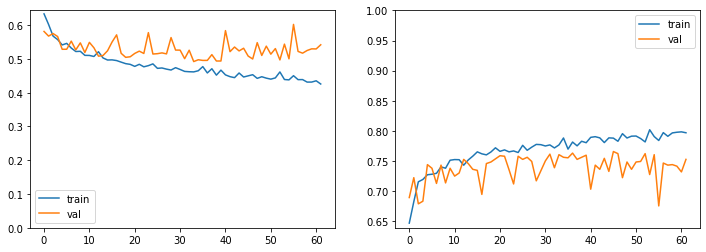

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6013 - accuracy: 0.6779 - precision: 0.9463 - recall: 0.6813 - f1: 0.7761 - specificity: 0.6784 - negative_predictive_value: 0.2290 - matthews_correlation_coefficient: 0.2479 - val_loss: 0.6166 - val_accuracy: 0.6739 - val_precision: 0.9547 - val_recall: 0.6272 - val_f1: 0.7538 - val_specificity: 0.8919 - val_negative_predictive_value: 0.2747 - val_matthews_correlation_coefficient: 0.3402

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34016, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_23-23_40_51.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5097 - accuracy: 0.7328 - precision: 0.9657 - recall: 0.7279 - f1: 0.8207 - specificity: 0.8072 - negative_predictive_value: 0.3167 - matthews_correlation_coefficient: 0.3770 - val_loss: 0.6250 - val_accuracy: 0.6756 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3977 - accuracy: 0.8200 - precision: 0.9751 - recall: 0.8202 - f1: 0.8879 - specificity: 0.8191 - negative_predictive_value: 0.3901 - matthews_correlation_coefficient: 0.4731 - val_loss: 0.3894 - val_accuracy: 0.8343 - val_precision: 0.9572 - val_recall: 0.8043 - val_f1: 0.8726 - val_specificity: 0.8770 - val_negative_predictive_value: 0.4118 - val_matthews_correlation_coefficient: 0.4929

Epoch 00015: val_matthews_correlation_coefficient improved from 0.47812 to 0.49295, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_23-23_40_51.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3898 - accuracy: 0.8215 - precision: 0.9735 - recall: 0.8192 - f1: 0.8858 - specificity: 0.8474 - negative_predictive_value: 0.3905 - matthews_correlation_coefficient: 0.4854 - val_loss: 0.6294 - val_accuracy: 0.7129 - val_precision: 0.9642 - val_recall: 0.6645 - val_f1: 0.7829 - val_s

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3696 - accuracy: 0.8239 - precision: 0.9775 - recall: 0.8222 - f1: 0.8903 - specificity: 0.8723 - negative_predictive_value: 0.4006 - matthews_correlation_coefficient: 0.4994 - val_loss: 0.4852 - val_accuracy: 0.7823 - val_precision: 0.9649 - val_recall: 0.7411 - val_f1: 0.8360 - val_specificity: 0.9292 - val_negative_predictive_value: 0.3597 - val_matthews_correlation_coefficient: 0.4575

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.51741
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3506 - accuracy: 0.8375 - precision: 0.9796 - recall: 0.8354 - f1: 0.9000 - specificity: 0.8370 - negative_predictive_value: 0.4087 - matthews_correlation_coefficient: 0.5047 - val_loss: 0.5290 - val_accuracy: 0.7589 - val_precision: 0.9645 - val_recall: 0.7144 - val_f1: 0.8183 - val_specificity: 0.9292 - val_negative_predictive_value: 0.3342 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3292 - accuracy: 0.8436 - precision: 0.9766 - recall: 0.8420 - f1: 0.9013 - specificity: 0.8373 - negative_predictive_value: 0.4227 - matthews_correlation_coefficient: 0.5161 - val_loss: 0.7706 - val_accuracy: 0.6739 - val_precision: 0.9636 - val_recall: 0.6214 - val_f1: 0.7515 - val_specificity: 0.9292 - val_negative_predictive_value: 0.2793 - val_matthews_correlation_coefficient: 0.3600

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.51741
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3706 - accuracy: 0.8156 - precision: 0.9793 - recall: 0.8114 - f1: 0.8832 - specificity: 0.8343 - negative_predictive_value: 0.3885 - matthews_correlation_coefficient: 0.4809 - val_loss: 0.5789 - val_accuracy: 0.7381 - val_precision: 0.9624 - val_recall: 0.6928 - val_f1: 0.8023 - val_specificity: 0.9253 - val_negative_predictive_value: 0.3243 - val_matthews_correlation_coefficie

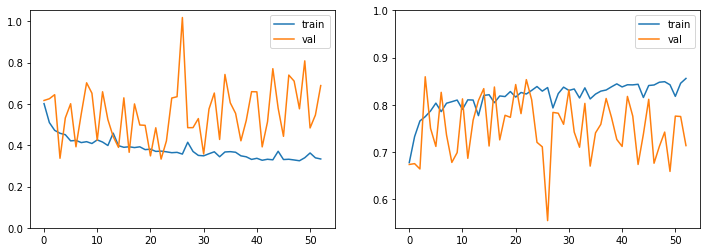

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5869 - accuracy: 0.7705 - precision: 0.9971 - recall: 0.7698 - f1: 0.8597 - specificity: 0.1552 - negative_predictive_value: 0.0278 - matthews_correlation_coefficient: 0.0528 - val_loss: 0.6172 - val_accuracy: 0.6045 - val_precision: 0.9988 - val_recall: 0.6124 - val_f1: 0.7550 - val_specificity: 0.1622 - val_negative_predictive_value: 0.0150 - val_matthews_correlation_coefficient: 0.0336

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.03360, saving model to ../models/autoencoders_requirements/washed_out_2020_03_23-23_48_43.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4308 - accuracy: 0.7954 - precision: 0.9992 - recall: 0.7956 - f1: 0.8798 - specificity: 0.2034 - negative_predictive_value: 0.0359 - matthews_correlation_coefficient: 0.0724 - val_loss: 0.0692 - val_accuracy: 0.9913 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.15683
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1090 - accuracy: 0.9725 - precision: 0.9998 - recall: 0.9726 - f1: 0.9852 - specificity: 0.2276 - negative_predictive_value: 0.1602 - matthews_correlation_coefficient: 0.1841 - val_loss: 0.0413 - val_accuracy: 0.9896 - val_precision: 0.9992 - val_recall: 0.9906 - val_f1: 0.9948 - val_specificity: 0.1622 - val_negative_predictive_value: 0.1486 - val_matthews_correlation_coefficient: 0.1536

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.15683
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0950 - accuracy: 0.9831 - precision: 0.9998 - recall: 0.9833 - f1: 0.9912 - specificity: 0.2483 - negative_predictive_value: 0.2048 - matthews_correlation_coefficient: 0.2204 - val_loss: 0.0525 - val_accuracy: 0.9879 - val_precision: 0.9992 - val_recall: 0.9889 - val_f1: 0.9939 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.15683
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0862 - accuracy: 0.9866 - precision: 0.9998 - recall: 0.9867 - f1: 0.9931 - specificity: 0.2345 - negative_predictive_value: 0.1933 - matthews_correlation_coefficient: 0.2082 - val_loss: 0.0630 - val_accuracy: 0.9887 - val_precision: 0.9992 - val_recall: 0.9898 - val_f1: 0.9943 - val_specificity: 0.1622 - val_negative_predictive_value: 0.1486 - val_matthews_correlation_coefficient: 0.1536

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.15683
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0805 - accuracy: 0.9911 - precision: 0.9998 - recall: 0.9913 - f1: 0.9955 - specificity: 0.2172 - negative_predictive_value: 0.1977 - matthews_correlation_coefficient: 0.2044 - val_loss: 0.0373 - val_accuracy: 0.9922 - val_precision: 0.9992 - val_recall: 0.9931 - val_f1: 0.9961 - val_spe

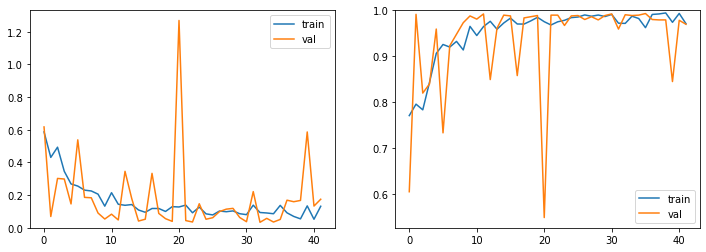

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6698 - accuracy: 0.5779 - precision: 0.9382 - recall: 0.5773 - f1: 0.6952 - specificity: 0.5731 - negative_predictive_value: 0.1095 - matthews_correlation_coefficient: 0.1159 - val_loss: 0.6201 - val_accuracy: 0.6938 - val_precision: 0.9639 - val_recall: 0.7035 - val_f1: 0.8101 - val_specificity: 0.5315 - val_negative_predictive_value: 0.1301 - val_matthews_correlation_coefficient: 0.1531

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.15306, saving model to ../models/autoencoders_requirements/pixelation_2020_03_23-23_54_59.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6492 - accuracy: 0.5915 - precision: 0.9632 - recall: 0.5886 - f1: 0.7166 - specificity: 0.5948 - negative_predictive_value: 0.1097 - matthews_correlation_coefficient: 0.1269 - val_loss: 0.5114 - val_accuracy: 0.7485 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5196 - accuracy: 0.6957 - precision: 0.9757 - recall: 0.6932 - f1: 0.8074 - specificity: 0.6819 - negative_predictive_value: 0.1533 - matthews_correlation_coefficient: 0.2220 - val_loss: 0.4527 - val_accuracy: 0.7268 - val_precision: 0.9720 - val_recall: 0.7337 - val_f1: 0.8334 - val_specificity: 0.6306 - val_negative_predictive_value: 0.1555 - val_matthews_correlation_coefficient: 0.2163

Epoch 00015: val_matthews_correlation_coefficient improved from 0.20402 to 0.21632, saving model to ../models/autoencoders_requirements/pixelation_2020_03_23-23_54_59.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5252 - accuracy: 0.7015 - precision: 0.9761 - recall: 0.6999 - f1: 0.8117 - specificity: 0.6816 - negative_predictive_value: 0.1549 - matthews_correlation_coefficient: 0.2257 - val_loss: 0.3370 - val_accuracy: 0.8066 - val_precision: 0.9593 - val_recall: 0.8317 - val_f1: 0.8899 - val_speci


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.22329
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4930 - accuracy: 0.7197 - precision: 0.9798 - recall: 0.7173 - f1: 0.8241 - specificity: 0.7122 - negative_predictive_value: 0.1802 - matthews_correlation_coefficient: 0.2632 - val_loss: 0.3744 - val_accuracy: 0.7927 - val_precision: 0.9625 - val_recall: 0.8137 - val_f1: 0.8802 - val_specificity: 0.4743 - val_negative_predictive_value: 0.1701 - val_matthews_correlation_coefficient: 0.1976

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.22329
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4805 - accuracy: 0.7210 - precision: 0.9807 - recall: 0.7175 - f1: 0.8236 - specificity: 0.7303 - negative_predictive_value: 0.1755 - matthews_correlation_coefficient: 0.2628 - val_loss: 0.2820 - val_accuracy: 0.8820 - val_precision: 0.9592 - val_recall: 0.9139 - val_f1: 0.9353 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.25088
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4712 - accuracy: 0.7256 - precision: 0.9823 - recall: 0.7174 - f1: 0.8268 - specificity: 0.7344 - negative_predictive_value: 0.1716 - matthews_correlation_coefficient: 0.2647 - val_loss: 0.3125 - val_accuracy: 0.8673 - val_precision: 0.9583 - val_recall: 0.8986 - val_f1: 0.9269 - val_specificity: 0.3676 - val_negative_predictive_value: 0.2165 - val_matthews_correlation_coefficient: 0.2156

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.25088
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4745 - accuracy: 0.7273 - precision: 0.9760 - recall: 0.7162 - f1: 0.8231 - specificity: 0.7143 - negative_predictive_value: 0.1788 - matthews_correlation_coefficient: 0.2634 - val_loss: 0.5529 - val_accuracy: 0.6487 - val_precision: 0.9702 - val_recall: 0.6514 - val_f1: 0.7766 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.25088
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4567 - accuracy: 0.7456 - precision: 0.9799 - recall: 0.7443 - f1: 0.8431 - specificity: 0.7317 - negative_predictive_value: 0.1889 - matthews_correlation_coefficient: 0.2799 - val_loss: 0.4719 - val_accuracy: 0.7190 - val_precision: 0.9733 - val_recall: 0.7231 - val_f1: 0.8269 - val_specificity: 0.6509 - val_negative_predictive_value: 0.1525 - val_matthews_correlation_coefficient: 0.2170

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.25088
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4721 - accuracy: 0.7243 - precision: 0.9804 - recall: 0.7216 - f1: 0.8277 - specificity: 0.6628 - negative_predictive_value: 0.1758 - matthews_correlation_coefficient: 0.2509 - val_loss: 0.3899 - val_accuracy: 0.7771 - val_precision: 0.9676 - val_recall: 0.7915 - val_f1: 0.8691 - val_spe

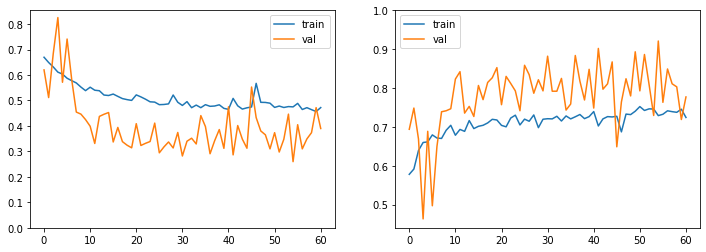

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5598 - accuracy: 0.6989 - precision: 0.9198 - recall: 0.6679 - f1: 0.7625 - specificity: 0.7887 - negative_predictive_value: 0.4187 - matthews_correlation_coefficient: 0.3970 - val_loss: 0.5140 - val_accuracy: 0.7173 - val_precision: 0.9098 - val_recall: 0.6555 - val_f1: 0.7588 - val_specificity: 0.8408 - val_negative_predictive_value: 0.4467 - val_matthews_correlation_coefficient: 0.4463

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.44629, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_24-00_04_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5386 - accuracy: 0.7128 - precision: 0.9317 - recall: 0.6741 - f1: 0.7772 - specificity: 0.8491 - negative_predictive_value: 0.4571 - matthews_correlation_coefficient: 0.4479 - val_loss: 0.5304 - val_accuracy: 0.7190 - val_preci

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4986 - accuracy: 0.7512 - precision: 0.9247 - recall: 0.7241 - f1: 0.8075 - specificity: 0.8221 - negative_predictive_value: 0.4947 - matthews_correlation_coefficient: 0.4824 - val_loss: 0.5158 - val_accuracy: 0.7329 - val_precision: 0.9128 - val_recall: 0.6745 - val_f1: 0.7733 - val_specificity: 0.8423 - val_negative_predictive_value: 0.4609 - val_matthews_correlation_coefficient: 0.4650

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.48430
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4963 - accuracy: 0.7475 - precision: 0.9250 - recall: 0.7259 - f1: 0.8087 - specificity: 0.8117 - negative_predictive_value: 0.4934 - matthews_correlation_coefficient: 0.4732 - val_loss: 0.5118 - val_accuracy: 0.7337 - val_precision: 0.9130 - val_recall: 0.6758 - val_f1: 0.7740 - val_specificity: 0.8423 - val_negative_predictive_value: 0.4629 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.49190
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4763 - accuracy: 0.7620 - precision: 0.9218 - recall: 0.7400 - f1: 0.8180 - specificity: 0.8136 - negative_predictive_value: 0.4993 - matthews_correlation_coefficient: 0.4796 - val_loss: 0.6679 - val_accuracy: 0.7147 - val_precision: 0.9173 - val_recall: 0.6453 - val_f1: 0.7550 - val_specificity: 0.8575 - val_negative_predictive_value: 0.4429 - val_matthews_correlation_coefficient: 0.4512

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.49190
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4815 - accuracy: 0.7594 - precision: 0.9318 - recall: 0.7400 - f1: 0.8200 - specificity: 0.8182 - negative_predictive_value: 0.5046 - matthews_correlation_coefficient: 0.4911 - val_loss: 0.4629 - val_accuracy: 0.7762 - val_precision: 0.9277 - val_recall: 0.7714 - val_f1: 0.8391 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.49707
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4604 - accuracy: 0.7744 - precision: 0.9302 - recall: 0.7618 - f1: 0.8333 - specificity: 0.8072 - negative_predictive_value: 0.5231 - matthews_correlation_coefficient: 0.5052 - val_loss: 0.4757 - val_accuracy: 0.7710 - val_precision: 0.9270 - val_recall: 0.7651 - val_f1: 0.8351 - val_specificity: 0.7942 - val_negative_predictive_value: 0.5091 - val_matthews_correlation_coefficient: 0.4920

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.49707
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4660 - accuracy: 0.7690 - precision: 0.9289 - recall: 0.7551 - f1: 0.8290 - specificity: 0.8190 - negative_predictive_value: 0.5166 - matthews_correlation_coefficient: 0.5031 - val_loss: 0.4980 - val_accuracy: 0.7736 - val_precision: 0.9301 - val_recall: 0.7660 - val_f1: 0.8369 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4488 - accuracy: 0.7850 - precision: 0.9325 - recall: 0.7748 - f1: 0.8428 - specificity: 0.8155 - negative_predictive_value: 0.5414 - matthews_correlation_coefficient: 0.5265 - val_loss: 0.6268 - val_accuracy: 0.7311 - val_precision: 0.9162 - val_recall: 0.6688 - val_f1: 0.7707 - val_specificity: 0.8517 - val_negative_predictive_value: 0.4599 - val_matthews_correlation_coefficient: 0.4681

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.50459
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4533 - accuracy: 0.7764 - precision: 0.9326 - recall: 0.7608 - f1: 0.8326 - specificity: 0.8292 - negative_predictive_value: 0.5264 - matthews_correlation_coefficient: 0.5190 - val_loss: 0.5886 - val_accuracy: 0.7355 - val_precision: 0.9165 - val_recall: 0.6742 - val_f1: 0.7742 - val_specificity: 0.8517 - val_negative_predictive_value: 0.4648 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4466 - accuracy: 0.7839 - precision: 0.9260 - recall: 0.7676 - f1: 0.8353 - specificity: 0.8078 - negative_predictive_value: 0.5362 - matthews_correlation_coefficient: 0.5200 - val_loss: 0.5534 - val_accuracy: 0.7363 - val_precision: 0.9131 - val_recall: 0.6790 - val_f1: 0.7761 - val_specificity: 0.8391 - val_negative_predictive_value: 0.4650 - val_matthews_correlation_coefficient: 0.4682

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.50459
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4387 - accuracy: 0.7783 - precision: 0.9374 - recall: 0.7596 - f1: 0.8352 - specificity: 0.8379 - negative_predictive_value: 0.5311 - matthews_correlation_coefficient: 0.5265 - val_loss: 0.5075 - val_accuracy: 0.7658 - val_precision: 0.9357 - val_recall: 0.7491 - val_f1: 0.8287 - val_specificity: 0.8163 - val_negative_predictive_value: 0.5018 - val_matthews_correlation_coefficie

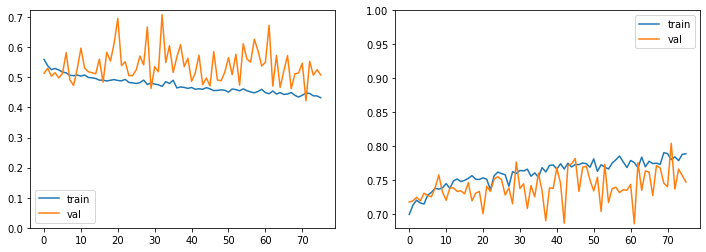

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6550 - accuracy: 0.5436 - precision: 0.8763 - recall: 0.4812 - f1: 0.6089 - specificity: 0.7596 - negative_predictive_value: 0.2967 - matthews_correlation_coefficient: 0.2092 - val_loss: 0.6952 - val_accuracy: 0.5195 - val_precision: 0.8656 - val_recall: 0.4280 - val_f1: 0.5662 - val_specificity: 0.7854 - val_negative_predictive_value: 0.2861 - val_matthews_correlation_coefficient: 0.2064

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20641, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_24-00_15_17.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6473 - accuracy: 0.5616 - precision: 0.8888 - recall: 0.5039 - f1: 0.6307 - specificity: 0.7521 - negative_predictive_value: 0.3048 - matthews_correlation_coefficient: 0.2219 - val_loss: 0.6453 - val_accuracy: 0.5377 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6099 - accuracy: 0.6421 - precision: 0.8957 - recall: 0.6117 - f1: 0.7185 - specificity: 0.7541 - negative_predictive_value: 0.3652 - matthews_correlation_coefficient: 0.3075 - val_loss: 0.6232 - val_accuracy: 0.6271 - val_precision: 0.8667 - val_recall: 0.5767 - val_f1: 0.6877 - val_specificity: 0.7386 - val_negative_predictive_value: 0.3417 - val_matthews_correlation_coefficient: 0.2830

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32921
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5918 - accuracy: 0.6640 - precision: 0.8952 - recall: 0.6487 - f1: 0.7451 - specificity: 0.7208 - negative_predictive_value: 0.3703 - matthews_correlation_coefficient: 0.3119 - val_loss: 0.5826 - val_accuracy: 0.6635 - val_precision: 0.8830 - val_recall: 0.6184 - val_f1: 0.7214 - val_specificity: 0.7642 - val_negative_predictive_value: 0.3728 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.36724
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5747 - accuracy: 0.6831 - precision: 0.8943 - recall: 0.6640 - f1: 0.7552 - specificity: 0.7208 - negative_predictive_value: 0.3879 - matthews_correlation_coefficient: 0.3346 - val_loss: 0.4941 - val_accuracy: 0.7589 - val_precision: 0.8806 - val_recall: 0.8084 - val_f1: 0.8400 - val_specificity: 0.6044 - val_negative_predictive_value: 0.4696 - val_matthews_correlation_coefficient: 0.3783

Epoch 00030: val_matthews_correlation_coefficient improved from 0.36724 to 0.37834, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_24-00_15_17.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5664 - accuracy: 0.6894 - precision: 0.9027 - recall: 0.6785 - f1: 0.7676 - specificity: 0.7381 - negative_predictive_value: 0.4001 - matthews_correlation_coefficient: 0.3523 - val_loss: 0.5919 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5500 - accuracy: 0.6978 - precision: 0.8897 - recall: 0.6853 - f1: 0.7678 - specificity: 0.7184 - negative_predictive_value: 0.4099 - matthews_correlation_coefficient: 0.3480 - val_loss: 0.5296 - val_accuracy: 0.7112 - val_precision: 0.8779 - val_recall: 0.6894 - val_f1: 0.7680 - val_specificity: 0.7235 - val_negative_predictive_value: 0.4164 - val_matthews_correlation_coefficient: 0.3743

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.37961
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5368 - accuracy: 0.7167 - precision: 0.9086 - recall: 0.7113 - f1: 0.7917 - specificity: 0.7426 - negative_predictive_value: 0.4342 - matthews_correlation_coefficient: 0.3915 - val_loss: 0.5194 - val_accuracy: 0.7381 - val_precision: 0.8775 - val_recall: 0.7259 - val_f1: 0.7906 - val_specificity: 0.7101 - val_negative_predictive_value: 0.4512 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.40390
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5330 - accuracy: 0.7117 - precision: 0.9035 - recall: 0.7044 - f1: 0.7842 - specificity: 0.7474 - negative_predictive_value: 0.4217 - matthews_correlation_coefficient: 0.3825 - val_loss: 0.5845 - val_accuracy: 0.6817 - val_precision: 0.8946 - val_recall: 0.6339 - val_f1: 0.7366 - val_specificity: 0.7877 - val_negative_predictive_value: 0.3930 - val_matthews_correlation_coefficient: 0.3742

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.40390
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5334 - accuracy: 0.7226 - precision: 0.8997 - recall: 0.7147 - f1: 0.7911 - specificity: 0.7473 - negative_predictive_value: 0.4330 - matthews_correlation_coefficient: 0.3907 - val_loss: 0.5362 - val_accuracy: 0.7112 - val_precision: 0.8889 - val_recall: 0.6767 - val_f1: 0.7639 - val_spe


Epoch 00073: val_matthews_correlation_coefficient improved from 0.40390 to 0.41717, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_24-00_15_17.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5151 - accuracy: 0.7282 - precision: 0.9115 - recall: 0.7260 - f1: 0.8005 - specificity: 0.7261 - negative_predictive_value: 0.4407 - matthews_correlation_coefficient: 0.3956 - val_loss: 0.5649 - val_accuracy: 0.7155 - val_precision: 0.8835 - val_recall: 0.6902 - val_f1: 0.7704 - val_specificity: 0.7390 - val_negative_predictive_value: 0.4229 - val_matthews_correlation_coefficient: 0.3884

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.41717
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5151 - accuracy: 0.7325 - precision: 0.9094 - recall: 0.7321 - f1: 0.8056 - specificity: 0.7429 - negative_predictive_value: 0.4530 - matthews_correlation_coefficient: 0.4108 - val_loss: 0.6604 - 


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.41717
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5129 - accuracy: 0.7245 - precision: 0.9014 - recall: 0.7164 - f1: 0.7932 - specificity: 0.7393 - negative_predictive_value: 0.4335 - matthews_correlation_coefficient: 0.3875 - val_loss: 0.4854 - val_accuracy: 0.7485 - val_precision: 0.8453 - val_recall: 0.7776 - val_f1: 0.8075 - val_specificity: 0.5830 - val_negative_predictive_value: 0.4481 - val_matthews_correlation_coefficient: 0.3502

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.41717
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5291 - accuracy: 0.7167 - precision: 0.9020 - recall: 0.7023 - f1: 0.7825 - specificity: 0.7520 - negative_predictive_value: 0.4343 - matthews_correlation_coefficient: 0.3881 - val_loss: 0.5720 - val_accuracy: 0.6869 - val_precision: 0.8914 - val_recall: 0.6431 - val_f1: 0.7414 - val_spe

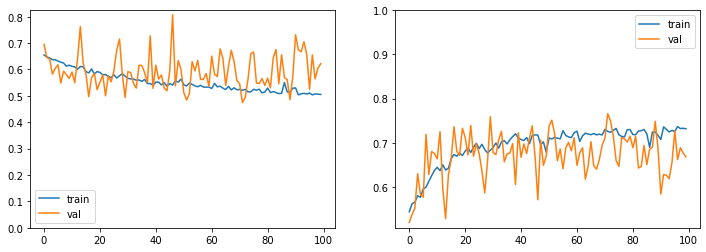

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5146 - accuracy: 0.7406 - precision: 0.8026 - recall: 0.7077 - f1: 0.7233 - specificity: 0.7769 - negative_predictive_value: 0.7289 - matthews_correlation_coefficient: 0.5071 - val_loss: 0.5323 - val_accuracy: 0.6852 - val_precision: 0.8972 - val_recall: 0.4437 - val_f1: 0.5822 - val_specificity: 0.9287 - val_negative_predictive_value: 0.5869 - val_matthews_correlation_coefficient: 0.4489

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.44894, saving model to ../models/autoencoders_requirements/varied_background_2020_03_24-00_30_12.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4333 - accuracy: 0.7729 - precision: 0.8201 - recall: 0.7668 - f1: 0.7751 - specificity: 0.7864 - negative_predictive_value: 0.7556 - matthews_correlation_coefficient: 0.5652 - val_loss: 0.4128 - val_accuracy: 0.7936 - val_prec


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.65899
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3487 - accuracy: 0.8273 - precision: 0.8654 - recall: 0.8158 - f1: 0.8326 - specificity: 0.8534 - negative_predictive_value: 0.8000 - matthews_correlation_coefficient: 0.6669 - val_loss: 0.3249 - val_accuracy: 0.8335 - val_precision: 0.8784 - val_recall: 0.8163 - val_f1: 0.8426 - val_specificity: 0.8364 - val_negative_predictive_value: 0.7708 - val_matthews_correlation_coefficient: 0.6506

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.65899
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3607 - accuracy: 0.8215 - precision: 0.8588 - recall: 0.8143 - f1: 0.8260 - specificity: 0.8346 - negative_predictive_value: 0.7902 - matthews_correlation_coefficient: 0.6502 - val_loss: 0.3345 - val_accuracy: 0.8231 - val_precision: 0.8270 - val_recall: 0.8649 - val_f1: 0.8422 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3145 - accuracy: 0.8499 - precision: 0.8715 - recall: 0.8339 - f1: 0.8473 - specificity: 0.8606 - negative_predictive_value: 0.8304 - matthews_correlation_coefficient: 0.6997 - val_loss: 0.3053 - val_accuracy: 0.8534 - val_precision: 0.8833 - val_recall: 0.8491 - val_f1: 0.8632 - val_specificity: 0.8404 - val_negative_predictive_value: 0.8010 - val_matthews_correlation_coefficient: 0.6867

Epoch 00029: val_matthews_correlation_coefficient improved from 0.68542 to 0.68668, saving model to ../models/autoencoders_requirements/varied_background_2020_03_24-00_30_12.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3282 - accuracy: 0.8414 - precision: 0.8701 - recall: 0.8419 - f1: 0.8495 - specificity: 0.8537 - negative_predictive_value: 0.8168 - matthews_correlation_coefficient: 0.6909 - val_loss: 0.2995 - val_accuracy: 0.8569 - val_precision: 0.9090 - val_recall: 0.8305 - val_f1: 0.8645 - va


Epoch 00043: val_matthews_correlation_coefficient improved from 0.69735 to 0.69769, saving model to ../models/autoencoders_requirements/varied_background_2020_03_24-00_30_12.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3091 - accuracy: 0.8505 - precision: 0.8791 - recall: 0.8404 - f1: 0.8531 - specificity: 0.8666 - negative_predictive_value: 0.8165 - matthews_correlation_coefficient: 0.7027 - val_loss: 0.3018 - val_accuracy: 0.8578 - val_precision: 0.8547 - val_recall: 0.8995 - val_f1: 0.8735 - val_specificity: 0.7928 - val_negative_predictive_value: 0.8428 - val_matthews_correlation_coefficient: 0.6946

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.69769
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3035 - accuracy: 0.8512 - precision: 0.8814 - recall: 0.8434 - f1: 0.8569 - specificity: 0.8639 - negative_predictive_value: 0.8177 - matthews_correlation_coefficient: 0.7029 - val_loss: 0.2


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.72033
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2893 - accuracy: 0.8601 - precision: 0.8970 - recall: 0.8440 - f1: 0.8649 - specificity: 0.8763 - negative_predictive_value: 0.8221 - matthews_correlation_coefficient: 0.7195 - val_loss: 0.3061 - val_accuracy: 0.8560 - val_precision: 0.8120 - val_recall: 0.9618 - val_f1: 0.8787 - val_specificity: 0.7089 - val_negative_predictive_value: 0.9173 - val_matthews_correlation_coefficient: 0.6986

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.72033
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2956 - accuracy: 0.8607 - precision: 0.8796 - recall: 0.8494 - f1: 0.8586 - specificity: 0.8704 - negative_predictive_value: 0.8397 - matthews_correlation_coefficient: 0.7207 - val_loss: 0.2787 - val_accuracy: 0.8664 - val_precision: 0.8778 - val_recall: 0.8837 - val_f1: 0.8778 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.73321
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2844 - accuracy: 0.8625 - precision: 0.8848 - recall: 0.8479 - f1: 0.8614 - specificity: 0.8745 - negative_predictive_value: 0.8380 - matthews_correlation_coefficient: 0.7241 - val_loss: 0.2900 - val_accuracy: 0.8656 - val_precision: 0.8639 - val_recall: 0.8971 - val_f1: 0.8775 - val_specificity: 0.8071 - val_negative_predictive_value: 0.8508 - val_matthews_correlation_coefficient: 0.7091

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73321
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2789 - accuracy: 0.8672 - precision: 0.8956 - recall: 0.8428 - f1: 0.8637 - specificity: 0.8867 - negative_predictive_value: 0.8292 - matthews_correlation_coefficient: 0.7338 - val_loss: 0.3006 - val_accuracy: 0.8612 - val_precision: 0.8264 - val_recall: 0.9489 - val_f1: 0.8812 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.73518
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2702 - accuracy: 0.8753 - precision: 0.9015 - recall: 0.8691 - f1: 0.8804 - specificity: 0.8850 - negative_predictive_value: 0.8445 - matthews_correlation_coefficient: 0.7498 - val_loss: 0.2553 - val_accuracy: 0.8768 - val_precision: 0.8967 - val_recall: 0.8806 - val_f1: 0.8863 - val_specificity: 0.8530 - val_negative_predictive_value: 0.8323 - val_matthews_correlation_coefficient: 0.7311

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.73518
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2584 - accuracy: 0.8766 - precision: 0.8926 - recall: 0.8630 - f1: 0.8731 - specificity: 0.8841 - negative_predictive_value: 0.8567 - matthews_correlation_coefficient: 0.7497 - val_loss: 0.2749 - val_accuracy: 0.8682 - val_precision: 0.8685 - val_recall: 0.8959 - val_f1: 0.8799 - val_spe

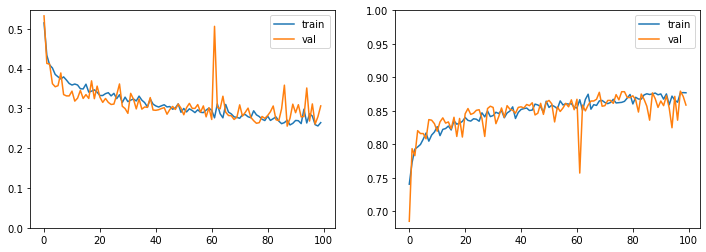

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5900 - accuracy: 0.7059 - precision: 0.9012 - recall: 0.6850 - f1: 0.7723 - specificity: 0.7774 - negative_predictive_value: 0.4471 - matthews_correlation_coefficient: 0.4005 - val_loss: 0.5889 - val_accuracy: 0.7086 - val_precision: 0.8988 - val_recall: 0.6506 - val_f1: 0.7495 - val_specificity: 0.8098 - val_negative_predictive_value: 0.4420 - val_matthews_correlation_coefficient: 0.4206

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.42060, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_24-00_44_59.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5734 - accuracy: 0.7106 - precision: 0.9098 - recall: 0.6860 - f1: 0.7793 - specificity: 0.7874 - negative_predictive_value: 0.4459 - matthews_correlation_coefficient: 0.4079 - val_loss: 0.5473 - val_accuracy: 0.7095 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5564 - accuracy: 0.7165 - precision: 0.9118 - recall: 0.6906 - f1: 0.7822 - specificity: 0.8051 - negative_predictive_value: 0.4589 - matthews_correlation_coefficient: 0.4263 - val_loss: 0.5697 - val_accuracy: 0.7103 - val_precision: 0.8926 - val_recall: 0.6573 - val_f1: 0.7518 - val_specificity: 0.7970 - val_negative_predictive_value: 0.4440 - val_matthews_correlation_coefficient: 0.4156

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.42470
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5570 - accuracy: 0.7102 - precision: 0.9105 - recall: 0.6818 - f1: 0.7756 - specificity: 0.7945 - negative_predictive_value: 0.4521 - matthews_correlation_coefficient: 0.4146 - val_loss: 0.5617 - val_accuracy: 0.7086 - val_precision: 0.8903 - val_recall: 0.6573 - val_f1: 0.7508 - val_specificity: 0.7928 - val_negative_predictive_value: 0.4423 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5487 - accuracy: 0.7154 - precision: 0.9117 - recall: 0.6894 - f1: 0.7824 - specificity: 0.7948 - negative_predictive_value: 0.4531 - matthews_correlation_coefficient: 0.4186 - val_loss: 0.5234 - val_accuracy: 0.7233 - val_precision: 0.8737 - val_recall: 0.6931 - val_f1: 0.7684 - val_specificity: 0.7383 - val_negative_predictive_value: 0.4573 - val_matthews_correlation_coefficient: 0.4027

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.42470
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5503 - accuracy: 0.7210 - precision: 0.9057 - recall: 0.6896 - f1: 0.7799 - specificity: 0.8023 - negative_predictive_value: 0.4600 - matthews_correlation_coefficient: 0.4216 - val_loss: 0.5380 - val_accuracy: 0.7147 - val_precision: 0.8819 - val_recall: 0.6728 - val_f1: 0.7584 - val_specificity: 0.7645 - val_negative_predictive_value: 0.4472 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5448 - accuracy: 0.7219 - precision: 0.9143 - recall: 0.6968 - f1: 0.7870 - specificity: 0.8022 - negative_predictive_value: 0.4635 - matthews_correlation_coefficient: 0.4322 - val_loss: 0.5168 - val_accuracy: 0.7233 - val_precision: 0.8733 - val_recall: 0.6933 - val_f1: 0.7690 - val_specificity: 0.7374 - val_negative_predictive_value: 0.4564 - val_matthews_correlation_coefficient: 0.4018

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42822
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5467 - accuracy: 0.7189 - precision: 0.9120 - recall: 0.6956 - f1: 0.7857 - specificity: 0.8032 - negative_predictive_value: 0.4671 - matthews_correlation_coefficient: 0.4325 - val_loss: 0.5594 - val_accuracy: 0.7138 - val_precision: 0.8983 - val_recall: 0.6575 - val_f1: 0.7541 - val_specificity: 0.8120 - val_negative_predictive_value: 0.4480 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5405 - accuracy: 0.7236 - precision: 0.9179 - recall: 0.6993 - f1: 0.7898 - specificity: 0.8055 - negative_predictive_value: 0.4674 - matthews_correlation_coefficient: 0.4393 - val_loss: 0.5277 - val_accuracy: 0.7259 - val_precision: 0.8674 - val_recall: 0.7020 - val_f1: 0.7721 - val_specificity: 0.7199 - val_negative_predictive_value: 0.4600 - val_matthews_correlation_coefficient: 0.3965

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.42822
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5367 - accuracy: 0.7258 - precision: 0.9163 - recall: 0.6990 - f1: 0.7893 - specificity: 0.8059 - negative_predictive_value: 0.4662 - matthews_correlation_coefficient: 0.4387 - val_loss: 0.5390 - val_accuracy: 0.7251 - val_precision: 0.8774 - val_recall: 0.6914 - val_f1: 0.7696 - val_specificity: 0.7521 - val_negative_predictive_value: 0.4581 - val_matthews_correlation_coefficie

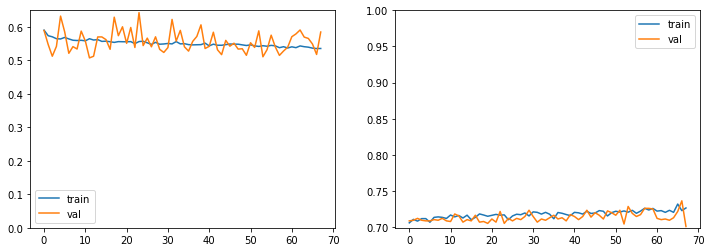

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6122 - accuracy: 0.6707 - precision: 0.7155 - recall: 0.6651 - f1: 0.6593 - specificity: 0.6597 - negative_predictive_value: 0.6268 - matthews_correlation_coefficient: 0.3493 - val_loss: 0.5798 - val_accuracy: 0.7129 - val_precision: 0.7394 - val_recall: 0.7344 - val_f1: 0.7319 - val_specificity: 0.6597 - val_negative_predictive_value: 0.6548 - val_matthews_correlation_coefficient: 0.3934

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.39342, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_24-00_55_05.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5589 - accuracy: 0.7367 - precision: 0.7755 - recall: 0.7927 - f1: 0.7752 - specificity: 0.6509 - negative_predictive_value: 0.6958 - matthews_correlation_coefficient: 0.4580 - val_loss: 0.5578 - val_accuracy: 0.7285 - v


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.53776
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4496 - accuracy: 0.8048 - precision: 0.8236 - recall: 0.8607 - f1: 0.8372 - specificity: 0.7290 - negative_predictive_value: 0.7842 - matthews_correlation_coefficient: 0.5977 - val_loss: 0.5416 - val_accuracy: 0.7389 - val_precision: 0.7744 - val_recall: 0.7341 - val_f1: 0.7499 - val_specificity: 0.7202 - val_negative_predictive_value: 0.6677 - val_matthews_correlation_coefficient: 0.4476

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.53776
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4516 - accuracy: 0.7989 - precision: 0.8160 - recall: 0.8509 - f1: 0.8253 - specificity: 0.7179 - negative_predictive_value: 0.7808 - matthews_correlation_coefficient: 0.5830 - val_loss: 0.4660 - val_accuracy: 0.7875 - val_precision: 0.7570 - val_recall: 0.8697 - val_f1: 0.8070 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4242 - accuracy: 0.8111 - precision: 0.8351 - recall: 0.8517 - f1: 0.8370 - specificity: 0.7490 - negative_predictive_value: 0.7771 - matthews_correlation_coefficient: 0.6073 - val_loss: 0.4470 - val_accuracy: 0.8083 - val_precision: 0.7992 - val_recall: 0.8374 - val_f1: 0.8160 - val_specificity: 0.7271 - val_negative_predictive_value: 0.7873 - val_matthews_correlation_coefficient: 0.5748

Epoch 00029: val_matthews_correlation_coefficient improved from 0.56843 to 0.57475, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_24-00_55_05.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4131 - accuracy: 0.8234 - precision: 0.8409 - recall: 0.8737 - f1: 0.8537 - specificity: 0.7561 - negative_predictive_value: 0.7989 - matthews_correlation_coefficient: 0.6341 - val_loss: 0.5089 - val_accuracy: 0.7719 - val_precision: 0.7938 - val_recall: 0.7691 - val_f1: 0.77


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.58908
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4133 - accuracy: 0.8154 - precision: 0.8462 - recall: 0.8528 - f1: 0.8426 - specificity: 0.7695 - negative_predictive_value: 0.7872 - matthews_correlation_coefficient: 0.6270 - val_loss: 0.4707 - val_accuracy: 0.7936 - val_precision: 0.8158 - val_recall: 0.7829 - val_f1: 0.7967 - val_specificity: 0.7742 - val_negative_predictive_value: 0.7324 - val_matthews_correlation_coefficient: 0.5523

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.58908
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4032 - accuracy: 0.8275 - precision: 0.8511 - recall: 0.8659 - f1: 0.8545 - specificity: 0.7777 - negative_predictive_value: 0.7960 - matthews_correlation_coefficient: 0.6447 - val_loss: 0.4434 - val_accuracy: 0.8092 - val_precision: 0.7830 - val_recall: 0.8703 - val_f1: 0.8220 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3972 - accuracy: 0.8321 - precision: 0.8491 - recall: 0.8656 - f1: 0.8527 - specificity: 0.7715 - negative_predictive_value: 0.8020 - matthews_correlation_coefficient: 0.6433 - val_loss: 0.4426 - val_accuracy: 0.8092 - val_precision: 0.8103 - val_recall: 0.8251 - val_f1: 0.8155 - val_specificity: 0.7514 - val_negative_predictive_value: 0.7713 - val_matthews_correlation_coefficient: 0.5786

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.59300
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4039 - accuracy: 0.8260 - precision: 0.8534 - recall: 0.8609 - f1: 0.8525 - specificity: 0.7840 - negative_predictive_value: 0.7886 - matthews_correlation_coefficient: 0.6426 - val_loss: 0.4553 - val_accuracy: 0.8049 - val_precision: 0.8161 - val_recall: 0.8079 - val_f1: 0.8100 - val_specificity: 0.7639 - val_negative_predictive_value: 0.7553 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3894 - accuracy: 0.8336 - precision: 0.8655 - recall: 0.8617 - f1: 0.8586 - specificity: 0.7981 - negative_predictive_value: 0.7897 - matthews_correlation_coefficient: 0.6570 - val_loss: 0.4403 - val_accuracy: 0.8144 - val_precision: 0.7898 - val_recall: 0.8703 - val_f1: 0.8253 - val_specificity: 0.6977 - val_negative_predictive_value: 0.8247 - val_matthews_correlation_coefficient: 0.5897

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.60224
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3746 - accuracy: 0.8479 - precision: 0.8701 - recall: 0.8765 - f1: 0.8704 - specificity: 0.8106 - negative_predictive_value: 0.8160 - matthews_correlation_coefficient: 0.6861 - val_loss: 0.4420 - val_accuracy: 0.8231 - val_precision: 0.8048 - val_recall: 0.8631 - val_f1: 0.8304 - val_specificity: 0.7293 - val_negative_predictive_value: 0.8193 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3765 - accuracy: 0.8403 - precision: 0.8595 - recall: 0.8632 - f1: 0.8573 - specificity: 0.8019 - negative_predictive_value: 0.8100 - matthews_correlation_coefficient: 0.6685 - val_loss: 0.4830 - val_accuracy: 0.7840 - val_precision: 0.8469 - val_recall: 0.7258 - val_f1: 0.7787 - val_specificity: 0.8353 - val_negative_predictive_value: 0.6962 - val_matthews_correlation_coefficient: 0.5515

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.60715
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3799 - accuracy: 0.8371 - precision: 0.8717 - recall: 0.8602 - f1: 0.8577 - specificity: 0.8101 - negative_predictive_value: 0.8067 - matthews_correlation_coefficient: 0.6734 - val_loss: 0.4214 - val_accuracy: 0.8179 - val_precision: 0.7959 - val_recall: 0.8671 - val_f1: 0.8274 - val_specificity: 0.7118 - val_negative_predictive_value: 0.8202 - val_matthews_correlation_coefficie

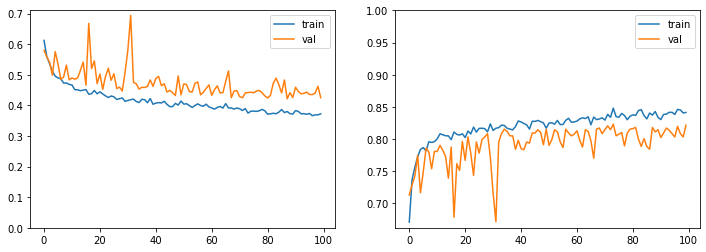

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.6467 - accuracy: 0.5401 - precision: 0.8782 - recall: 0.4743 - f1: 0.5986 - specificity: 0.7508 - negative_predictive_value: 0.2895 - matthews_correlation_coefficient: 0.1972 - val_loss: 0.5707 - val_accuracy: 0.6305 - val_precision: 0.8300 - val_recall: 0.6745 - val_f1: 0.7397 - val_specificity: 0.5094 - val_negative_predictive_value: 0.3069 - val_matthews_correlation_coefficient: 0.1576

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.15763, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_24-01_09_48.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6393 - accuracy: 0.5408 - precision: 0.8883 - recall: 0.4695 - f1: 0.5985 - specificity: 0.7842 - negative_predictive_value: 0.3080 - matthews_correlation_coefficient: 0.2215 - val_loss: 0.7602 - val_accuracy: 0.4562 - val_precision: 0


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.31271
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5892 - accuracy: 0.6492 - precision: 0.9050 - recall: 0.6161 - f1: 0.7235 - specificity: 0.7700 - negative_predictive_value: 0.3741 - matthews_correlation_coefficient: 0.3253 - val_loss: 0.5425 - val_accuracy: 0.6921 - val_precision: 0.8445 - val_recall: 0.6883 - val_f1: 0.7566 - val_specificity: 0.6219 - val_negative_predictive_value: 0.3794 - val_matthews_correlation_coefficient: 0.2899

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.31271
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5815 - accuracy: 0.6685 - precision: 0.9044 - recall: 0.6477 - f1: 0.7439 - specificity: 0.7569 - negative_predictive_value: 0.3973 - matthews_correlation_coefficient: 0.3468 - val_loss: 0.6138 - val_accuracy: 0.6479 - val_precision: 0.8842 - val_recall: 0.5871 - val_f1: 0.7006 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5529 - accuracy: 0.6922 - precision: 0.9037 - recall: 0.6771 - f1: 0.7650 - specificity: 0.7413 - negative_predictive_value: 0.4105 - matthews_correlation_coefficient: 0.3608 - val_loss: 0.5607 - val_accuracy: 0.7051 - val_precision: 0.8737 - val_recall: 0.6760 - val_f1: 0.7594 - val_specificity: 0.7204 - val_negative_predictive_value: 0.4111 - val_matthews_correlation_coefficient: 0.3616

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.36541
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5487 - accuracy: 0.6959 - precision: 0.9045 - recall: 0.6777 - f1: 0.7695 - specificity: 0.7465 - negative_predictive_value: 0.4093 - matthews_correlation_coefficient: 0.3636 - val_loss: 0.5466 - val_accuracy: 0.6904 - val_precision: 0.8919 - val_recall: 0.6917 - val_f1: 0.7734 - val_specificity: 0.6879 - val_negative_predictive_value: 0.3983 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.38103
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5333 - accuracy: 0.7054 - precision: 0.9172 - recall: 0.6896 - f1: 0.7794 - specificity: 0.7736 - negative_predictive_value: 0.4347 - matthews_correlation_coefficient: 0.4007 - val_loss: 0.7010 - val_accuracy: 0.6062 - val_precision: 0.9016 - val_recall: 0.5180 - val_f1: 0.6513 - val_specificity: 0.8379 - val_negative_predictive_value: 0.3475 - val_matthews_correlation_coefficient: 0.3235

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.38103
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5318 - accuracy: 0.7022 - precision: 0.9100 - recall: 0.6845 - f1: 0.7747 - specificity: 0.7646 - negative_predictive_value: 0.4183 - matthews_correlation_coefficient: 0.3807 - val_loss: 0.6160 - val_accuracy: 0.6409 - val_precision: 0.8995 - val_recall: 0.5656 - val_f1: 0.6893 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5114 - accuracy: 0.7195 - precision: 0.9209 - recall: 0.6948 - f1: 0.7864 - specificity: 0.7958 - negative_predictive_value: 0.4402 - matthews_correlation_coefficient: 0.4199 - val_loss: 0.5445 - val_accuracy: 0.6947 - val_precision: 0.8852 - val_recall: 0.7040 - val_f1: 0.7807 - val_specificity: 0.6775 - val_negative_predictive_value: 0.4032 - val_matthews_correlation_coefficient: 0.3300

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.40985
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5189 - accuracy: 0.7156 - precision: 0.9138 - recall: 0.6993 - f1: 0.7835 - specificity: 0.7732 - negative_predictive_value: 0.4356 - matthews_correlation_coefficient: 0.4048 - val_loss: 0.6119 - val_accuracy: 0.6626 - val_precision: 0.8965 - val_recall: 0.5963 - val_f1: 0.7125 - val_specificity: 0.8063 - val_negative_predictive_value: 0.3823 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5114 - accuracy: 0.7260 - precision: 0.9161 - recall: 0.7158 - f1: 0.7961 - specificity: 0.7619 - negative_predictive_value: 0.4465 - matthews_correlation_coefficient: 0.4122 - val_loss: 0.5917 - val_accuracy: 0.6722 - val_precision: 0.9044 - val_recall: 0.6029 - val_f1: 0.7183 - val_specificity: 0.8246 - val_negative_predictive_value: 0.3955 - val_matthews_correlation_coefficient: 0.3834

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.40985
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5168 - accuracy: 0.7184 - precision: 0.9073 - recall: 0.7092 - f1: 0.7889 - specificity: 0.7525 - negative_predictive_value: 0.4401 - matthews_correlation_coefficient: 0.3978 - val_loss: 0.7127 - val_accuracy: 0.5794 - val_precision: 0.9204 - val_recall: 0.4689 - val_f1: 0.6156 - val_specificity: 0.8831 - val_negative_predictive_value: 0.3353 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.41028
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5060 - accuracy: 0.7280 - precision: 0.9207 - recall: 0.7096 - f1: 0.7952 - specificity: 0.7742 - negative_predictive_value: 0.4423 - matthews_correlation_coefficient: 0.4170 - val_loss: 0.5568 - val_accuracy: 0.6878 - val_precision: 0.8931 - val_recall: 0.6363 - val_f1: 0.7396 - val_specificity: 0.7853 - val_negative_predictive_value: 0.4021 - val_matthews_correlation_coefficient: 0.3785

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.41028
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5007 - accuracy: 0.7217 - precision: 0.9128 - recall: 0.7096 - f1: 0.7921 - specificity: 0.7681 - negative_predictive_value: 0.4392 - matthews_correlation_coefficient: 0.4062 - val_loss: 0.5143 - val_accuracy: 0.7129 - val_precision: 0.8939 - val_recall: 0.7239 - val_f1: 0.7957 - val_spe

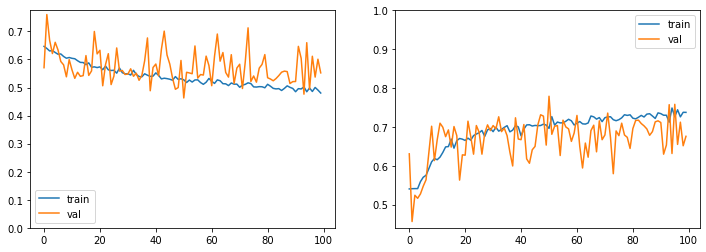

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5007 - accuracy: 0.7323 - precision: 0.8671 - recall: 0.6884 - f1: 0.7554 - specificity: 0.8037 - negative_predictive_value: 0.5928 - matthews_correlation_coefficient: 0.4810 - val_loss: 0.4997 - val_accuracy: 0.7233 - val_precision: 0.8795 - val_recall: 0.6734 - val_f1: 0.7572 - val_specificity: 0.8119 - val_negative_predictive_value: 0.5635 - val_matthews_correlation_coefficient: 0.4626

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.46255, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_24-01_24_39.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4609 - accuracy: 0.7597 - precision: 0.9015 - recall: 0.7091 - f1: 0.7865 - specificity: 0.8484 - negative_predictive_value: 0.6122 - matthews_correlation_coefficient: 0.5356 - val_loss: 0.4662 - val_accuracy: 0.7650 - val_p


Epoch 00014: val_matthews_correlation_coefficient improved from 0.58606 to 0.59842, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_24-01_24_39.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3939 - accuracy: 0.8061 - precision: 0.9098 - recall: 0.7703 - f1: 0.8302 - specificity: 0.8660 - negative_predictive_value: 0.6706 - matthews_correlation_coefficient: 0.6138 - val_loss: 0.4290 - val_accuracy: 0.7910 - val_precision: 0.9330 - val_recall: 0.7383 - val_f1: 0.8178 - val_specificity: 0.8716 - val_negative_predictive_value: 0.6308 - val_matthews_correlation_coefficient: 0.5852

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.59842
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4058 - accuracy: 0.8013 - precision: 0.9141 - recall: 0.7705 - f1: 0.8293 - specificity: 0.8699 - negative_predictive_value: 0.6686 - matthews_correlation_coefficient: 0.6117 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3649 - accuracy: 0.8304 - precision: 0.9221 - recall: 0.8074 - f1: 0.8569 - specificity: 0.8735 - negative_predictive_value: 0.7043 - matthews_correlation_coefficient: 0.6541 - val_loss: 0.4111 - val_accuracy: 0.8109 - val_precision: 0.9288 - val_recall: 0.7760 - val_f1: 0.8401 - val_specificity: 0.8584 - val_negative_predictive_value: 0.6629 - val_matthews_correlation_coefficient: 0.6117

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.63218
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3686 - accuracy: 0.8315 - precision: 0.9173 - recall: 0.8155 - f1: 0.8588 - specificity: 0.8650 - negative_predictive_value: 0.7135 - matthews_correlation_coefficient: 0.6558 - val_loss: 0.3971 - val_accuracy: 0.8101 - val_precision: 0.8758 - val_recall: 0.8329 - val_f1: 0.8495 - val_specificity: 0.7613 - val_negative_predictive_value: 0.6992 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.64441
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3433 - accuracy: 0.8495 - precision: 0.9266 - recall: 0.8367 - f1: 0.8750 - specificity: 0.8649 - negative_predictive_value: 0.7414 - matthews_correlation_coefficient: 0.6852 - val_loss: 0.3726 - val_accuracy: 0.8205 - val_precision: 0.8353 - val_recall: 0.9114 - val_f1: 0.8689 - val_specificity: 0.6396 - val_negative_predictive_value: 0.7768 - val_matthews_correlation_coefficient: 0.5794

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.64441
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3421 - accuracy: 0.8514 - precision: 0.9173 - recall: 0.8378 - f1: 0.8726 - specificity: 0.8719 - negative_predictive_value: 0.7496 - matthews_correlation_coefficient: 0.6891 - val_loss: 0.3698 - val_accuracy: 0.8343 - val_precision: 0.9160 - val_recall: 0.8296 - val_f1: 0.8665 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3357 - accuracy: 0.8557 - precision: 0.9292 - recall: 0.8412 - f1: 0.8803 - specificity: 0.8761 - negative_predictive_value: 0.7472 - matthews_correlation_coefficient: 0.6960 - val_loss: 0.3514 - val_accuracy: 0.8543 - val_precision: 0.9072 - val_recall: 0.8730 - val_f1: 0.8865 - val_specificity: 0.8034 - val_negative_predictive_value: 0.7499 - val_matthews_correlation_coefficient: 0.6661

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.67730
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3406 - accuracy: 0.8523 - precision: 0.9195 - recall: 0.8493 - f1: 0.8774 - specificity: 0.8617 - negative_predictive_value: 0.7513 - matthews_correlation_coefficient: 0.6911 - val_loss: 0.3631 - val_accuracy: 0.8448 - val_precision: 0.9217 - val_recall: 0.8412 - val_f1: 0.8753 - val_specificity: 0.8343 - val_negative_predictive_value: 0.7200 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3202 - accuracy: 0.8612 - precision: 0.9334 - recall: 0.8498 - f1: 0.8863 - specificity: 0.8826 - negative_predictive_value: 0.7589 - matthews_correlation_coefficient: 0.7113 - val_loss: 0.3523 - val_accuracy: 0.8491 - val_precision: 0.9197 - val_recall: 0.8498 - val_f1: 0.8802 - val_specificity: 0.8335 - val_negative_predictive_value: 0.7276 - val_matthews_correlation_coefficient: 0.6644

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.67735
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3059 - accuracy: 0.8703 - precision: 0.9289 - recall: 0.8634 - f1: 0.8918 - specificity: 0.8783 - negative_predictive_value: 0.7766 - matthews_correlation_coefficient: 0.7244 - val_loss: 0.3659 - val_accuracy: 0.8343 - val_precision: 0.9028 - val_recall: 0.8436 - val_f1: 0.8686 - val_specificity: 0.7972 - val_negative_predictive_value: 0.7129 - val_matthews_correlation_coefficie


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.68979
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2976 - accuracy: 0.8716 - precision: 0.9356 - recall: 0.8652 - f1: 0.8958 - specificity: 0.8832 - negative_predictive_value: 0.7707 - matthews_correlation_coefficient: 0.7256 - val_loss: 0.3294 - val_accuracy: 0.8690 - val_precision: 0.9024 - val_recall: 0.9039 - val_f1: 0.9002 - val_specificity: 0.7883 - val_negative_predictive_value: 0.7968 - val_matthews_correlation_coefficient: 0.6952

Epoch 00087: val_matthews_correlation_coefficient improved from 0.68979 to 0.69518, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_24-01_24_39.h5
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3021 - accuracy: 0.8738 - precision: 0.9362 - recall: 0.8685 - f1: 0.8980 - specificity: 0.8845 - negative_predictive_value: 0.7817 - matthews_correlation_coefficient: 0.7341 - val_loss: 0

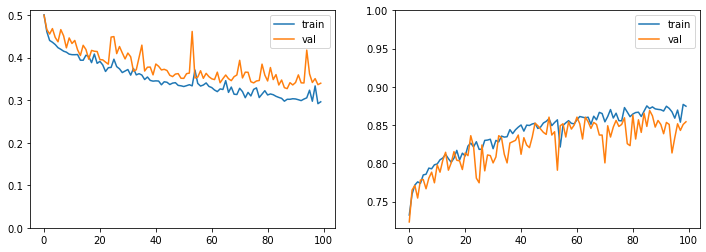

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6162 - accuracy: 0.6453 - precision: 0.7121 - recall: 0.6220 - f1: 0.6300 - specificity: 0.6563 - negative_predictive_value: 0.6060 - matthews_correlation_coefficient: 0.2972 - val_loss: 0.6933 - val_accuracy: 0.5603 - val_precision: 0.8395 - val_recall: 0.2900 - val_f1: 0.4138 - val_specificity: 0.9086 - val_negative_predictive_value: 0.4854 - val_matthews_correlation_coefficient: 0.2504

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25035, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_24-01_39_45.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5937 - accuracy: 0.6707 - precision: 0.7343 - recall: 0.6722 - f1: 0.6786 - specificity: 0.6704 - negative_predictive_value: 0.6310 - matthews_correlation_coefficient: 0.3527 - val_loss: 0.5828 - val_accuracy: 0.6904 - val_p


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.44896
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5361 - accuracy: 0.7341 - precision: 0.7708 - recall: 0.7683 - f1: 0.7582 - specificity: 0.6995 - negative_predictive_value: 0.7015 - matthews_correlation_coefficient: 0.4711 - val_loss: 0.5350 - val_accuracy: 0.7398 - val_precision: 0.7335 - val_recall: 0.8684 - val_f1: 0.7915 - val_specificity: 0.5639 - val_negative_predictive_value: 0.7370 - val_matthews_correlation_coefficient: 0.4503

Epoch 00015: val_matthews_correlation_coefficient improved from 0.44896 to 0.45035, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_24-01_39_45.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5323 - accuracy: 0.7317 - precision: 0.7733 - recall: 0.7385 - f1: 0.7454 - specificity: 0.7196 - negative_predictive_value: 0.6860 - matthews_correlation_coefficient: 0.4650 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4934 - accuracy: 0.7670 - precision: 0.7890 - recall: 0.7902 - f1: 0.7835 - specificity: 0.7266 - negative_predictive_value: 0.7467 - matthews_correlation_coefficient: 0.5254 - val_loss: 0.5333 - val_accuracy: 0.7537 - val_precision: 0.7952 - val_recall: 0.7011 - val_f1: 0.7418 - val_specificity: 0.7818 - val_negative_predictive_value: 0.6702 - val_matthews_correlation_coefficient: 0.5009

Epoch 00029: val_matthews_correlation_coefficient improved from 0.46876 to 0.50094, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_24-01_39_45.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4952 - accuracy: 0.7616 - precision: 0.7984 - recall: 0.7852 - f1: 0.7833 - specificity: 0.7403 - negative_predictive_value: 0.7349 - matthews_correlation_coefficient: 0.5287 - val_loss: 0.5305 - val_accuracy: 0.7580 - val_precision: 0.8086 - val_recall: 0.7600 - val_f1: 0.7789 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4782 - accuracy: 0.7694 - precision: 0.8106 - recall: 0.7788 - f1: 0.7889 - specificity: 0.7632 - negative_predictive_value: 0.7287 - matthews_correlation_coefficient: 0.5402 - val_loss: 0.5126 - val_accuracy: 0.7632 - val_precision: 0.7718 - val_recall: 0.8362 - val_f1: 0.7989 - val_specificity: 0.6576 - val_negative_predictive_value: 0.7372 - val_matthews_correlation_coefficient: 0.5009

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.51632
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4721 - accuracy: 0.7722 - precision: 0.8011 - recall: 0.7848 - f1: 0.7875 - specificity: 0.7536 - negative_predictive_value: 0.7333 - matthews_correlation_coefficient: 0.5375 - val_loss: 0.5160 - val_accuracy: 0.7502 - val_precision: 0.7509 - val_recall: 0.8389 - val_f1: 0.7893 - val_specificity: 0.6208 - val_negative_predictive_value: 0.7335 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.52182
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4646 - accuracy: 0.7764 - precision: 0.8245 - recall: 0.7777 - f1: 0.7926 - specificity: 0.7705 - negative_predictive_value: 0.7294 - matthews_correlation_coefficient: 0.5506 - val_loss: 0.5094 - val_accuracy: 0.7641 - val_precision: 0.7492 - val_recall: 0.8907 - val_f1: 0.8103 - val_specificity: 0.5885 - val_negative_predictive_value: 0.7792 - val_matthews_correlation_coefficient: 0.5023

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.52182
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4537 - accuracy: 0.7852 - precision: 0.8131 - recall: 0.7918 - f1: 0.7958 - specificity: 0.7728 - negative_predictive_value: 0.7514 - matthews_correlation_coefficient: 0.5638 - val_loss: 0.5471 - val_accuracy: 0.7441 - val_precision: 0.7530 - val_recall: 0.7491 - val_f1: 0.7474 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.53191
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4583 - accuracy: 0.7770 - precision: 0.8114 - recall: 0.7789 - f1: 0.7882 - specificity: 0.7599 - negative_predictive_value: 0.7360 - matthews_correlation_coefficient: 0.5495 - val_loss: 0.5449 - val_accuracy: 0.7467 - val_precision: 0.7808 - val_recall: 0.7071 - val_f1: 0.7376 - val_specificity: 0.7544 - val_negative_predictive_value: 0.6697 - val_matthews_correlation_coefficient: 0.4828

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.53191
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4547 - accuracy: 0.7794 - precision: 0.8288 - recall: 0.7728 - f1: 0.7923 - specificity: 0.7804 - negative_predictive_value: 0.7269 - matthews_correlation_coefficient: 0.5557 - val_loss: 0.5514 - val_accuracy: 0.7259 - val_precision: 0.7349 - val_recall: 0.7329 - val_f1: 0.7293 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.53870
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4441 - accuracy: 0.7924 - precision: 0.8309 - recall: 0.7991 - f1: 0.8085 - specificity: 0.7828 - negative_predictive_value: 0.7494 - matthews_correlation_coefficient: 0.5806 - val_loss: 0.5419 - val_accuracy: 0.7502 - val_precision: 0.7349 - val_recall: 0.7964 - val_f1: 0.7613 - val_specificity: 0.6471 - val_negative_predictive_value: 0.7169 - val_matthews_correlation_coefficient: 0.4744

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.53870
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4345 - accuracy: 0.7922 - precision: 0.8277 - recall: 0.7879 - f1: 0.8020 - specificity: 0.7892 - negative_predictive_value: 0.7492 - matthews_correlation_coefficient: 0.5784 - val_loss: 0.5036 - val_accuracy: 0.7702 - val_precision: 0.7842 - val_recall: 0.7577 - val_f1: 0.7668 - val_spe

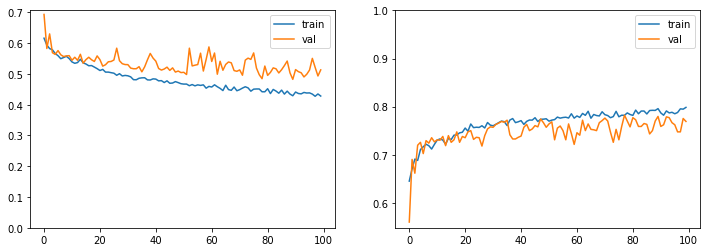

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5776 - accuracy: 0.5362 - precision: 0.9630 - recall: 0.4917 - f1: 0.6452 - specificity: 0.8576 - negative_predictive_value: 0.1822 - matthews_correlation_coefficient: 0.2254 - val_loss: 0.7165 - val_accuracy: 0.4657 - val_precision: 0.9556 - val_recall: 0.3949 - val_f1: 0.5530 - val_specificity: 0.9316 - val_negative_predictive_value: 0.1866 - val_matthews_correlation_coefficient: 0.2134

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21341, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_24-01_54_37.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5594 - accuracy: 0.5644 - precision: 0.9672 - recall: 0.5310 - f1: 0.6773 - specificity: 0.8021 - negative_predictive_value: 0.1880 - matthews_correlation_coefficient: 0.2286 - val_loss: 0.5532 - val_accuracy: 0.5256 - val_pr


Epoch 00014: val_matthews_correlation_coefficient improved from 0.31574 to 0.32630, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_24-01_54_37.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4531 - accuracy: 0.7184 - precision: 0.9659 - recall: 0.6996 - f1: 0.8051 - specificity: 0.8323 - negative_predictive_value: 0.2765 - matthews_correlation_coefficient: 0.3575 - val_loss: 0.5992 - val_accuracy: 0.6193 - val_precision: 0.9542 - val_recall: 0.5650 - val_f1: 0.7052 - val_specificity: 0.9077 - val_negative_predictive_value: 0.2354 - val_matthews_correlation_coefficient: 0.2939

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32630
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4412 - accuracy: 0.7230 - precision: 0.9746 - recall: 0.7101 - f1: 0.8156 - specificity: 0.8325 - negative_predictive_value: 0.2776 - matthews_correlation_coefficient: 0.3617 - val_loss: 0.


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.43355
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3900 - accuracy: 0.7707 - precision: 0.9836 - recall: 0.7538 - f1: 0.8487 - specificity: 0.8725 - negative_predictive_value: 0.3243 - matthews_correlation_coefficient: 0.4319 - val_loss: 0.3865 - val_accuracy: 0.7832 - val_precision: 0.9473 - val_recall: 0.7567 - val_f1: 0.8385 - val_specificity: 0.8082 - val_negative_predictive_value: 0.3182 - val_matthews_correlation_coefficient: 0.4066

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43355
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4014 - accuracy: 0.7657 - precision: 0.9779 - recall: 0.7569 - f1: 0.8476 - specificity: 0.8568 - negative_predictive_value: 0.3330 - matthews_correlation_coefficient: 0.4283 - val_loss: 0.4464 - val_accuracy: 0.7398 - val_precision: 0.9582 - val_recall: 0.6975 - val_f1: 0.8049 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45898
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3917 - accuracy: 0.7740 - precision: 0.9801 - recall: 0.7617 - f1: 0.8490 - specificity: 0.8286 - negative_predictive_value: 0.3388 - matthews_correlation_coefficient: 0.4262 - val_loss: 0.4029 - val_accuracy: 0.7580 - val_precision: 0.9664 - val_recall: 0.7112 - val_f1: 0.8166 - val_specificity: 0.9358 - val_negative_predictive_value: 0.3258 - val_matthews_correlation_coefficient: 0.4271

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45898
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3711 - accuracy: 0.7720 - precision: 0.9814 - recall: 0.7604 - f1: 0.8522 - specificity: 0.8684 - negative_predictive_value: 0.3247 - matthews_correlation_coefficient: 0.4286 - val_loss: 0.3138 - val_accuracy: 0.8404 - val_precision: 0.9490 - val_recall: 0.8183 - val_f1: 0.8779 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3805 - accuracy: 0.7692 - precision: 0.9765 - recall: 0.7496 - f1: 0.8405 - specificity: 0.8502 - negative_predictive_value: 0.3389 - matthews_correlation_coefficient: 0.4289 - val_loss: 0.6904 - val_accuracy: 0.6271 - val_precision: 0.9713 - val_recall: 0.5638 - val_f1: 0.7092 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2442 - val_matthews_correlation_coefficient: 0.3333

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.48598
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3834 - accuracy: 0.7711 - precision: 0.9807 - recall: 0.7553 - f1: 0.8455 - specificity: 0.8507 - negative_predictive_value: 0.3412 - matthews_correlation_coefficient: 0.4309 - val_loss: 0.4416 - val_accuracy: 0.7398 - val_precision: 0.9688 - val_recall: 0.6891 - val_f1: 0.8027 - val_specificity: 0.9562 - val_negative_predictive_value: 0.3081 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3363 - accuracy: 0.8087 - precision: 0.9832 - recall: 0.8005 - f1: 0.8779 - specificity: 0.8717 - negative_predictive_value: 0.3681 - matthews_correlation_coefficient: 0.4772 - val_loss: 0.5905 - val_accuracy: 0.6791 - val_precision: 0.9713 - val_recall: 0.6208 - val_f1: 0.7540 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2704 - val_matthews_correlation_coefficient: 0.3714

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.48598
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3366 - accuracy: 0.8078 - precision: 0.9824 - recall: 0.7990 - f1: 0.8760 - specificity: 0.8469 - negative_predictive_value: 0.3832 - matthews_correlation_coefficient: 0.4750 - val_loss: 0.7185 - val_accuracy: 0.6219 - val_precision: 0.9712 - val_recall: 0.5583 - val_f1: 0.7052 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2426 - val_matthews_correlation_coefficie

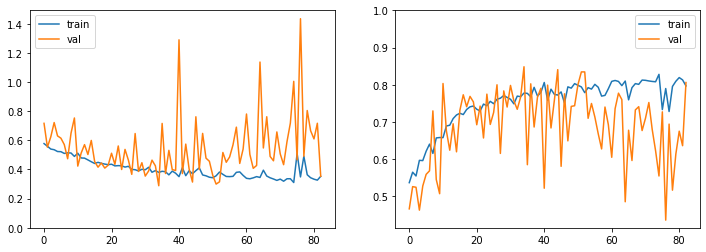

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5804 - accuracy: 0.6616 - precision: 0.9078 - recall: 0.6467 - f1: 0.7472 - specificity: 0.7323 - negative_predictive_value: 0.3487 - matthews_correlation_coefficient: 0.3085 - val_loss: 0.5292 - val_accuracy: 0.7415 - val_precision: 0.8593 - val_recall: 0.8148 - val_f1: 0.8348 - val_specificity: 0.4544 - val_negative_predictive_value: 0.3833 - val_matthews_correlation_coefficient: 0.2538

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25383, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_24-02_07_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5695 - accuracy: 0.7028 - precision: 0.8944 - recall: 0.7032 - f1: 0.7788 - specificity: 0.6916 - negative_predictive_value: 0.3911 - matthews_correlation_coefficient: 0.3379 - val_loss: 0.7942 - val_accuracy: 0.5091 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5299 - accuracy: 0.7015 - precision: 0.9185 - recall: 0.6867 - f1: 0.7796 - specificity: 0.7627 - negative_predictive_value: 0.3923 - matthews_correlation_coefficient: 0.3711 - val_loss: 0.5055 - val_accuracy: 0.7372 - val_precision: 0.8901 - val_recall: 0.7724 - val_f1: 0.8242 - val_specificity: 0.6124 - val_negative_predictive_value: 0.4071 - val_matthews_correlation_coefficient: 0.3362

Epoch 00014: val_matthews_correlation_coefficient improved from 0.32999 to 0.33624, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_24-02_07_01.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5254 - accuracy: 0.7156 - precision: 0.9147 - recall: 0.7137 - f1: 0.7948 - specificity: 0.7482 - negative_predictive_value: 0.4057 - matthews_correlation_coefficient: 0.3800 - val_loss: 0.5087 - val_accuracy: 0.7112 - val_precision: 0.9011 - val_recall: 0.7249 - val_f1: 0.


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.41638
Epoch 28/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5127 - accuracy: 0.7076 - precision: 0.9266 - recall: 0.6918 - f1: 0.7837 - specificity: 0.7821 - negative_predictive_value: 0.4090 - matthews_correlation_coefficient: 0.3959 - val_loss: 0.4966 - val_accuracy: 0.6999 - val_precision: 0.9256 - val_recall: 0.6873 - val_f1: 0.7830 - val_specificity: 0.7671 - val_negative_predictive_value: 0.3897 - val_matthews_correlation_coefficient: 0.3766

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.41638
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5009 - accuracy: 0.7445 - precision: 0.9213 - recall: 0.7432 - f1: 0.8179 - specificity: 0.7526 - negative_predictive_value: 0.4379 - matthews_correlation_coefficient: 0.4175 - val_loss: 0.5480 - val_accuracy: 0.6912 - val_precision: 0.9353 - val_recall: 0.6676 - val_f1: 0.7725 - val_spe


Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.41804
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4912 - accuracy: 0.7382 - precision: 0.9261 - recall: 0.7336 - f1: 0.8121 - specificity: 0.7633 - negative_predictive_value: 0.4336 - matthews_correlation_coefficient: 0.4193 - val_loss: 0.5422 - val_accuracy: 0.7008 - val_precision: 0.9380 - val_recall: 0.6787 - val_f1: 0.7813 - val_specificity: 0.8037 - val_negative_predictive_value: 0.3929 - val_matthews_correlation_coefficient: 0.3976

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.41804
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4772 - accuracy: 0.7538 - precision: 0.9288 - recall: 0.7495 - f1: 0.8234 - specificity: 0.7753 - negative_predictive_value: 0.4600 - matthews_correlation_coefficient: 0.4490 - val_loss: 0.6464 - val_accuracy: 0.6036 - val_precision: 0.9555 - val_recall: 0.5381 - val_f1: 0.6779 - val_spe


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.41804
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4638 - accuracy: 0.7640 - precision: 0.9331 - recall: 0.7560 - f1: 0.8295 - specificity: 0.7786 - negative_predictive_value: 0.4658 - matthews_correlation_coefficient: 0.4599 - val_loss: 0.5054 - val_accuracy: 0.6999 - val_precision: 0.9052 - val_recall: 0.7040 - val_f1: 0.7866 - val_specificity: 0.7020 - val_negative_predictive_value: 0.3867 - val_matthews_correlation_coefficient: 0.3426

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.41804
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4602 - accuracy: 0.7672 - precision: 0.9345 - recall: 0.7644 - f1: 0.8351 - specificity: 0.7791 - negative_predictive_value: 0.4771 - matthews_correlation_coefficient: 0.4691 - val_loss: 0.5292 - val_accuracy: 0.6912 - val_precision: 0.9377 - val_recall: 0.6667 - val_f1: 0.7709 - val_spe

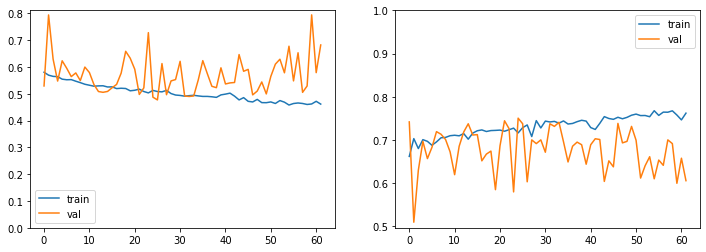

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6419 - accuracy: 0.8189 - precision: 0.9983 - recall: 0.8210 - f1: 0.8900 - specificity: 0.0483 - negative_predictive_value: 0.0063 - matthews_correlation_coefficient: 0.0128 - val_loss: 0.2751 - val_accuracy: 0.8951 - val_precision: 0.9972 - val_recall: 0.9000 - val_f1: 0.9451 - val_specificity: 0.0270 - val_negative_predictive_value: 0.0054 - val_matthews_correlation_coefficient: 0.0068

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00676, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_24-02_16_22.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5511 - accuracy: 0.6987 - precision: 0.9990 - recall: 0.7008 - f1: 0.8079 - specificity: 0.0690 - negative_predictive_value: 0.0119 - matthews_correlation_coefficient: 0.0220 - val_loss: 0.3480 - val_accuracy: 0.8456 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2810 - accuracy: 0.8390 - precision: 0.9998 - recall: 0.8399 - f1: 0.9075 - specificity: 0.0793 - negative_predictive_value: 0.0368 - matthews_correlation_coefficient: 0.0451 - val_loss: 0.4399 - val_accuracy: 0.7346 - val_precision: 1.0000 - val_recall: 0.7408 - val_f1: 0.8479 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0136 - val_matthews_correlation_coefficient: 0.0337

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2318 - accuracy: 0.8701 - precision: 1.0000 - recall: 0.8707 - f1: 0.9285 - specificity: 0.0966 - negative_predictive_value: 0.0398 - matthews_correlation_coefficient: 0.0570 - val_loss: 0.2069 - val_accuracy: 0.9115 - val_precision: 1.0000 - val_recall: 0.9136 - val_f1: 0.9544 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0360 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2273 - accuracy: 0.8794 - precision: 0.9996 - recall: 0.8801 - f1: 0.9309 - specificity: 0.0759 - negative_predictive_value: 0.0290 - matthews_correlation_coefficient: 0.0387 - val_loss: 0.2019 - val_accuracy: 0.8838 - val_precision: 0.9991 - val_recall: 0.8874 - val_f1: 0.9389 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0405 - val_matthews_correlation_coefficient: 0.0507

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2304 - accuracy: 0.8774 - precision: 0.9996 - recall: 0.8752 - f1: 0.9302 - specificity: 0.0759 - negative_predictive_value: 0.0281 - matthews_correlation_coefficient: 0.0420 - val_loss: 0.3902 - val_accuracy: 0.7892 - val_precision: 1.0000 - val_recall: 0.7941 - val_f1: 0.8832 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0154 - val_matthews_correlation_coefficie


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.10811
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2508 - accuracy: 0.9132 - precision: 0.9998 - recall: 0.9138 - f1: 0.9508 - specificity: 0.0897 - negative_predictive_value: 0.0533 - matthews_correlation_coefficient: 0.0641 - val_loss: 0.1360 - val_accuracy: 0.9410 - val_precision: 1.0000 - val_recall: 0.9425 - val_f1: 0.9700 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0631 - val_matthews_correlation_coefficient: 0.0797

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.10811
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2711 - accuracy: 0.8816 - precision: 0.9995 - recall: 0.8823 - f1: 0.9347 - specificity: 0.0759 - negative_predictive_value: 0.0199 - matthews_correlation_coefficient: 0.0324 - val_loss: 0.1879 - val_accuracy: 0.9332 - val_precision: 1.0000 - val_recall: 0.9348 - val_f1: 0.9660 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.10811
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0959 - accuracy: 0.9397 - precision: 1.0000 - recall: 0.9399 - f1: 0.9675 - specificity: 0.0966 - negative_predictive_value: 0.0582 - matthews_correlation_coefficient: 0.0707 - val_loss: 0.0478 - val_accuracy: 0.9801 - val_precision: 1.0000 - val_recall: 0.9805 - val_f1: 0.9900 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0946 - val_matthews_correlation_coefficient: 0.0999

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.10811
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1941 - accuracy: 0.8944 - precision: 0.9998 - recall: 0.8950 - f1: 0.9400 - specificity: 0.0897 - negative_predictive_value: 0.0361 - matthews_correlation_coefficient: 0.0512 - val_loss: 0.0614 - val_accuracy: 0.9792 - val_precision: 0.9991 - val_recall: 0.9805 - val_f1: 0.9896 - val_spe

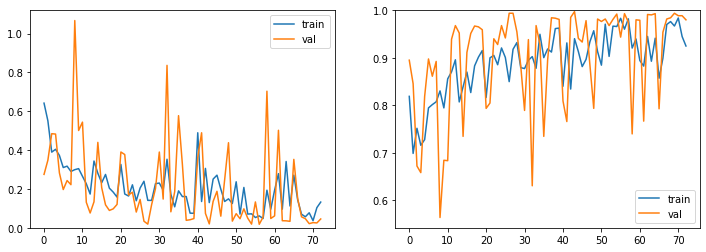

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6013 - accuracy: 0.6215 - precision: 0.8797 - recall: 0.5608 - f1: 0.6656 - specificity: 0.7702 - negative_predictive_value: 0.3872 - matthews_correlation_coefficient: 0.3021 - val_loss: 0.5903 - val_accuracy: 0.6696 - val_precision: 0.8335 - val_recall: 0.6300 - val_f1: 0.7129 - val_specificity: 0.6952 - val_negative_predictive_value: 0.4268 - val_matthews_correlation_coefficient: 0.3169

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.31694, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_24-02_27_19.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5892 - accuracy: 0.6421 - precision: 0.8874 - recall: 0.5858 - f1: 0.6948 - specificity: 0.8035 - negative_predictive_value: 0.4316 - matthews_correlation_coefficient: 0.3507 - val_loss: 0.6050 - val_accuracy: 0.6592 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5501 - accuracy: 0.6874 - precision: 0.9095 - recall: 0.6412 - f1: 0.7447 - specificity: 0.8290 - negative_predictive_value: 0.4709 - matthews_correlation_coefficient: 0.4208 - val_loss: 0.6120 - val_accuracy: 0.6670 - val_precision: 0.8651 - val_recall: 0.6021 - val_f1: 0.7052 - val_specificity: 0.7734 - val_negative_predictive_value: 0.4272 - val_matthews_correlation_coefficient: 0.3570

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39297
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5504 - accuracy: 0.6857 - precision: 0.9058 - recall: 0.6390 - f1: 0.7442 - specificity: 0.8217 - negative_predictive_value: 0.4590 - matthews_correlation_coefficient: 0.4081 - val_loss: 0.5516 - val_accuracy: 0.6843 - val_precision: 0.8400 - val_recall: 0.6512 - val_f1: 0.7297 - val_specificity: 0.6960 - val_negative_predictive_value: 0.4387 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40083
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5185 - accuracy: 0.7076 - precision: 0.9115 - recall: 0.6621 - f1: 0.7614 - specificity: 0.8241 - negative_predictive_value: 0.4783 - matthews_correlation_coefficient: 0.4353 - val_loss: 0.6134 - val_accuracy: 0.6661 - val_precision: 0.9029 - val_recall: 0.5695 - val_f1: 0.6927 - val_specificity: 0.8538 - val_negative_predictive_value: 0.4341 - val_matthews_correlation_coefficient: 0.4030

Epoch 00030: val_matthews_correlation_coefficient improved from 0.40083 to 0.40296, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_24-02_27_19.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5160 - accuracy: 0.7104 - precision: 0.9211 - recall: 0.6618 - f1: 0.7651 - specificity: 0.8547 - negative_predictive_value: 0.4898 - matthews_correlation_coefficient: 0.4588 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4992 - accuracy: 0.7217 - precision: 0.9182 - recall: 0.6701 - f1: 0.7703 - specificity: 0.8405 - negative_predictive_value: 0.4972 - matthews_correlation_coefficient: 0.4602 - val_loss: 0.6549 - val_accuracy: 0.6496 - val_precision: 0.9100 - val_recall: 0.5420 - val_f1: 0.6725 - val_specificity: 0.8634 - val_negative_predictive_value: 0.4226 - val_matthews_correlation_coefficient: 0.3924

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44049
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5049 - accuracy: 0.7165 - precision: 0.9213 - recall: 0.6653 - f1: 0.7660 - specificity: 0.8435 - negative_predictive_value: 0.4933 - matthews_correlation_coefficient: 0.4589 - val_loss: 0.5200 - val_accuracy: 0.7060 - val_precision: 0.8415 - val_recall: 0.6825 - val_f1: 0.7502 - val_specificity: 0.6931 - val_negative_predictive_value: 0.4687 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4838 - accuracy: 0.7293 - precision: 0.9183 - recall: 0.6810 - f1: 0.7769 - specificity: 0.8433 - negative_predictive_value: 0.5039 - matthews_correlation_coefficient: 0.4681 - val_loss: 0.5615 - val_accuracy: 0.7069 - val_precision: 0.8886 - val_recall: 0.6399 - val_f1: 0.7397 - val_specificity: 0.8130 - val_negative_predictive_value: 0.4689 - val_matthews_correlation_coefficient: 0.4279

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.44049
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4838 - accuracy: 0.7388 - precision: 0.9263 - recall: 0.6985 - f1: 0.7921 - specificity: 0.8390 - negative_predictive_value: 0.5072 - matthews_correlation_coefficient: 0.4807 - val_loss: 0.5663 - val_accuracy: 0.6930 - val_precision: 0.8919 - val_recall: 0.6168 - val_f1: 0.7239 - val_specificity: 0.8252 - val_negative_predictive_value: 0.4582 - val_matthews_correlation_coefficie

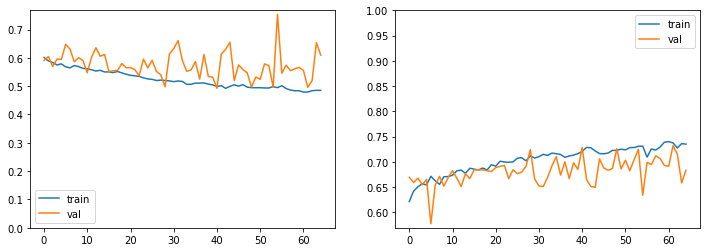

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5987 - accuracy: 0.5911 - precision: 0.9311 - recall: 0.5690 - f1: 0.6940 - specificity: 0.7235 - negative_predictive_value: 0.2277 - matthews_correlation_coefficient: 0.2131 - val_loss: 0.4422 - val_accuracy: 0.7858 - val_precision: 0.8814 - val_recall: 0.8149 - val_f1: 0.8446 - val_specificity: 0.4818 - val_negative_predictive_value: 0.3382 - val_matthews_correlation_coefficient: 0.2756

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27557, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_24-02_38_11.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5526 - accuracy: 0.6488 - precision: 0.9496 - recall: 0.6278 - f1: 0.7457 - specificity: 0.7780 - negative_predictive_value: 0.2730 - matthews_correlation_coefficient: 0.2988 - val_loss: 0.4593 - val_accuracy: 0.7580 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5271 - accuracy: 0.6759 - precision: 0.9466 - recall: 0.6527 - f1: 0.7546 - specificity: 0.7999 - negative_predictive_value: 0.3058 - matthews_correlation_coefficient: 0.3407 - val_loss: 0.4798 - val_accuracy: 0.7259 - val_precision: 0.9567 - val_recall: 0.7207 - val_f1: 0.8179 - val_specificity: 0.8000 - val_negative_predictive_value: 0.3098 - val_matthews_correlation_coefficient: 0.3640

Epoch 00015: val_matthews_correlation_coefficient improved from 0.36082 to 0.36399, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_24-02_38_11.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4795 - accuracy: 0.7143 - precision: 0.9528 - recall: 0.7027 - f1: 0.8016 - specificity: 0.7951 - negative_predictive_value: 0.3213 - matthews_correlation_coefficient: 0.3670 - val_loss: 0.4082 - val_accuracy: 0.7728 - val_precision: 0.9322 - val_recall: 0.8006 - val_f1: 0.8587 - val_specific

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4393 - accuracy: 0.7475 - precision: 0.9587 - recall: 0.7399 - f1: 0.8299 - specificity: 0.7952 - negative_predictive_value: 0.3504 - matthews_correlation_coefficient: 0.3985 - val_loss: 0.3574 - val_accuracy: 0.8083 - val_precision: 0.9161 - val_recall: 0.8606 - val_f1: 0.8860 - val_specificity: 0.4953 - val_negative_predictive_value: 0.3602 - val_matthews_correlation_coefficient: 0.3065

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40241
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4354 - accuracy: 0.7508 - precision: 0.9607 - recall: 0.7425 - f1: 0.8326 - specificity: 0.8015 - negative_predictive_value: 0.3532 - matthews_correlation_coefficient: 0.4066 - val_loss: 0.3613 - val_accuracy: 0.8014 - val_precision: 0.9367 - val_recall: 0.8314 - val_f1: 0.8786 - val_specificity: 0.6050 - val_negative_predictive_value: 0.3684 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.43038
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4046 - accuracy: 0.7757 - precision: 0.9638 - recall: 0.7657 - f1: 0.8484 - specificity: 0.8279 - negative_predictive_value: 0.3829 - matthews_correlation_coefficient: 0.4474 - val_loss: 0.3547 - val_accuracy: 0.8144 - val_precision: 0.9325 - val_recall: 0.8511 - val_f1: 0.8882 - val_specificity: 0.6237 - val_negative_predictive_value: 0.3901 - val_matthews_correlation_coefficient: 0.3828

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.43038
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4082 - accuracy: 0.7696 - precision: 0.9691 - recall: 0.7581 - f1: 0.8460 - specificity: 0.8416 - negative_predictive_value: 0.3716 - matthews_correlation_coefficient: 0.4453 - val_loss: 0.3060 - val_accuracy: 0.8595 - val_precision: 0.9178 - val_recall: 0.9227 - val_f1: 0.9189 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4006 - accuracy: 0.7807 - precision: 0.9644 - recall: 0.7739 - f1: 0.8522 - specificity: 0.8358 - negative_predictive_value: 0.3953 - matthews_correlation_coefficient: 0.4630 - val_loss: 0.3068 - val_accuracy: 0.8491 - val_precision: 0.9139 - val_recall: 0.9140 - val_f1: 0.9128 - val_specificity: 0.4628 - val_negative_predictive_value: 0.4703 - val_matthews_correlation_coefficient: 0.3732

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.44657
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3943 - accuracy: 0.7911 - precision: 0.9694 - recall: 0.7833 - f1: 0.8631 - specificity: 0.8552 - negative_predictive_value: 0.4047 - matthews_correlation_coefficient: 0.4792 - val_loss: 0.3336 - val_accuracy: 0.8300 - val_precision: 0.9152 - val_recall: 0.8901 - val_f1: 0.9008 - val_specificity: 0.4911 - val_negative_predictive_value: 0.4187 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.46237
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3659 - accuracy: 0.7991 - precision: 0.9654 - recall: 0.7842 - f1: 0.8613 - specificity: 0.8464 - negative_predictive_value: 0.4137 - matthews_correlation_coefficient: 0.4891 - val_loss: 0.3829 - val_accuracy: 0.8144 - val_precision: 0.9573 - val_recall: 0.8265 - val_f1: 0.8842 - val_specificity: 0.7567 - val_negative_predictive_value: 0.4187 - val_matthews_correlation_coefficient: 0.4601

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46237
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4540 - accuracy: 0.7521 - precision: 0.9663 - recall: 0.7394 - f1: 0.8213 - specificity: 0.8006 - negative_predictive_value: 0.3737 - matthews_correlation_coefficient: 0.4213 - val_loss: 0.3496 - val_accuracy: 0.8395 - val_precision: 0.9307 - val_recall: 0.8833 - val_f1: 0.9047 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.46544
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3432 - accuracy: 0.8258 - precision: 0.9752 - recall: 0.8191 - f1: 0.8867 - specificity: 0.8705 - negative_predictive_value: 0.4650 - matthews_correlation_coefficient: 0.5421 - val_loss: 0.3041 - val_accuracy: 0.8543 - val_precision: 0.9162 - val_recall: 0.9196 - val_f1: 0.9165 - val_specificity: 0.4689 - val_negative_predictive_value: 0.4743 - val_matthews_correlation_coefficient: 0.3804

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.46544
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3589 - accuracy: 0.8050 - precision: 0.9740 - recall: 0.7973 - f1: 0.8728 - specificity: 0.8602 - negative_predictive_value: 0.4301 - matthews_correlation_coefficient: 0.5070 - val_loss: 0.2862 - val_accuracy: 0.8708 - val_precision: 0.9316 - val_recall: 0.9211 - val_f1: 0.9250 - val_spe

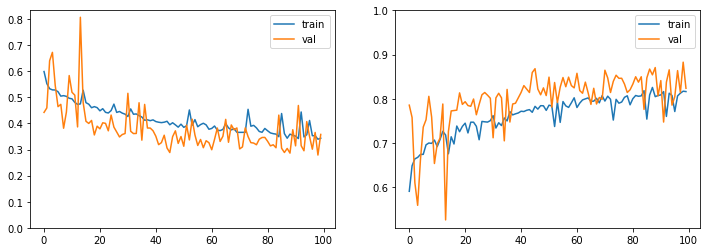

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4151 - accuracy: 0.7818 - precision: 0.9921 - recall: 0.7720 - f1: 0.8622 - specificity: 0.8027 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.3807 - val_accuracy: 0.8387 - val_precision: 0.9643 - val_recall: 0.8136 - val_f1: 0.8811 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2588 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38286, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_24-02_53_10.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - precision: 0.9917 - recall: 0.8666 - f1: 0.9230 - specificity: 0.7196 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.4039 - val_accuracy: 0.8491 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.9158 - precision: 0.9932 - recall: 0.9173 - f1: 0.9524 - specificity: 0.8023 - negative_predictive_value: 0.4604 - matthews_correlation_coefficient: 0.5620 - val_loss: 0.1886 - val_accuracy: 0.9376 - val_precision: 0.9635 - val_recall: 0.9180 - val_f1: 0.9398 - val_specificity: 0.7477 - val_negative_predictive_value: 0.4450 - val_matthews_correlation_coefficient: 0.5381

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2488 - accuracy: 0.9197 - precision: 0.9918 - recall: 0.9224 - f1: 0.9549 - specificity: 0.7823 - negative_predictive_value: 0.4400 - matthews_correlation_coefficient: 0.5401 - val_loss: 0.2038 - val_accuracy: 0.9384 - val_precision: 0.9635 - val_recall: 0.9189 - val_f1: 0.9402 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2005 - accuracy: 0.9386 - precision: 0.9939 - recall: 0.9377 - f1: 0.9638 - specificity: 0.7611 - negative_predictive_value: 0.5021 - matthews_correlation_coefficient: 0.5830 - val_loss: 0.1303 - val_accuracy: 0.9636 - val_precision: 0.9908 - val_recall: 0.9710 - val_f1: 0.9805 - val_specificity: 0.7658 - val_negative_predictive_value: 0.5948 - val_matthews_correlation_coefficient: 0.6447

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59848 to 0.64469, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_24-02_53_10.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2301 - accuracy: 0.9278 - precision: 0.9891 - recall: 0.9306 - f1: 0.9568 - specificity: 0.7816 - negative_predictive_value: 0.4989 - matthews_correlation_coefficient: 0.5805 - val_loss: 0.3644 - val_accuracy: 0.8942 - val_precision: 0.9669 - val_recall: 0.8696 - val_f1: 0.9149 - val_s


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.64469
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1746 - accuracy: 0.9403 - precision: 0.9942 - recall: 0.9425 - f1: 0.9666 - specificity: 0.7902 - negative_predictive_value: 0.5440 - matthews_correlation_coefficient: 0.6154 - val_loss: 0.1422 - val_accuracy: 0.9575 - val_precision: 0.9673 - val_recall: 0.9352 - val_f1: 0.9506 - val_specificity: 0.8063 - val_negative_predictive_value: 0.6011 - val_matthews_correlation_coefficient: 0.6642

Epoch 00044: val_matthews_correlation_coefficient improved from 0.64469 to 0.66424, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_24-02_53_10.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1627 - accuracy: 0.9538 - precision: 0.9942 - recall: 0.9566 - f1: 0.9745 - specificity: 0.8156 - negative_predictive_value: 0.5999 - matthews_correlation_coefficient: 0.6658 - val_loss: 0.2724

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1434 - accuracy: 0.9544 - precision: 0.9951 - recall: 0.9569 - f1: 0.9749 - specificity: 0.7929 - negative_predictive_value: 0.6069 - matthews_correlation_coefficient: 0.6603 - val_loss: 0.3438 - val_accuracy: 0.8907 - val_precision: 0.9700 - val_recall: 0.8630 - val_f1: 0.9128 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3313 - val_matthews_correlation_coefficient: 0.4800

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1640 - accuracy: 0.9471 - precision: 0.9953 - recall: 0.9483 - f1: 0.9700 - specificity: 0.8495 - negative_predictive_value: 0.5979 - matthews_correlation_coefficient: 0.6767 - val_loss: 0.4156 - val_accuracy: 0.8716 - val_precision: 0.9688 - val_recall: 0.8444 - val_f1: 0.9017 - val_specificity: 0.8266 - val_negative_predictive_value: 0.2989 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1380 - accuracy: 0.9555 - precision: 0.9955 - recall: 0.9576 - f1: 0.9757 - specificity: 0.8283 - negative_predictive_value: 0.5924 - matthews_correlation_coefficient: 0.6659 - val_loss: 0.2782 - val_accuracy: 0.8699 - val_precision: 0.9698 - val_recall: 0.8411 - val_f1: 0.9001 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3008 - val_matthews_correlation_coefficient: 0.4507

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1275 - accuracy: 0.9586 - precision: 0.9964 - recall: 0.9596 - f1: 0.9771 - specificity: 0.8432 - negative_predictive_value: 0.6287 - matthews_correlation_coefficient: 0.6968 - val_loss: 0.1736 - val_accuracy: 0.9228 - val_precision: 0.9959 - val_recall: 0.9228 - val_f1: 0.9576 - val_specificity: 0.8279 - val_negative_predictive_value: 0.4162 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 00087: early stopping

   Final Accuracy:  98.01%
  Final Precision:  99.35%
     Final Recall:  98.52%
  Final F-measure:  98.93%
Final Specificity:  90.41%
        Final NPV:  80.49%
        Final MCC:  84.26%
[[  66    7]
 [  16 1064]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        73
           1       0.99      0.99      0.99      1080

    accuracy                           0.98      1153
   macro avg       0.90      0.94      0.92      1153
weighted avg       0.98      0.98      0.98      1153



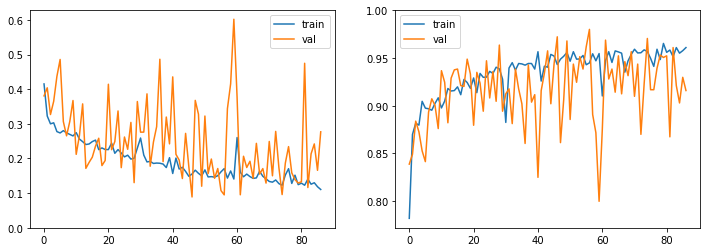

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6134 - accuracy: 0.6514 - precision: 0.8704 - recall: 0.6099 - f1: 0.7073 - specificity: 0.7546 - negative_predictive_value: 0.4097 - matthews_correlation_coefficient: 0.3204 - val_loss: 0.5982 - val_accuracy: 0.6219 - val_precision: 0.8429 - val_recall: 0.5527 - val_f1: 0.6635 - val_specificity: 0.7771 - val_negative_predictive_value: 0.4126 - val_matthews_correlation_coefficient: 0.2887

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28871, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_24-03_06_12.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5865 - accuracy: 0.6640 - precision: 0.8841 - recall: 0.6304 - f1: 0.7289 - specificity: 0.7783 - negative_predictive_value: 0.4365 - matthews_correlation_coefficient: 0.3596 - val_loss: 0.6206 - val_accuracy: 0.6331 - val_precision:


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.34715
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5541 - accuracy: 0.6813 - precision: 0.8885 - recall: 0.6493 - f1: 0.7446 - specificity: 0.7748 - negative_predictive_value: 0.4521 - matthews_correlation_coefficient: 0.3782 - val_loss: 0.6090 - val_accuracy: 0.6444 - val_precision: 0.8676 - val_recall: 0.5690 - val_f1: 0.6831 - val_specificity: 0.8143 - val_negative_predictive_value: 0.4330 - val_matthews_correlation_coefficient: 0.3377

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.34715
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5512 - accuracy: 0.6976 - precision: 0.8897 - recall: 0.6697 - f1: 0.7597 - specificity: 0.7790 - negative_predictive_value: 0.4637 - matthews_correlation_coefficient: 0.3977 - val_loss: 0.5938 - val_accuracy: 0.6513 - val_precision: 0.8545 - val_recall: 0.5897 - val_f1: 0.6940 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.35087
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5365 - accuracy: 0.7020 - precision: 0.8931 - recall: 0.6730 - f1: 0.7619 - specificity: 0.7783 - negative_predictive_value: 0.4726 - matthews_correlation_coefficient: 0.4059 - val_loss: 0.6170 - val_accuracy: 0.6418 - val_precision: 0.8535 - val_recall: 0.5739 - val_f1: 0.6828 - val_specificity: 0.7923 - val_negative_predictive_value: 0.4294 - val_matthews_correlation_coefficient: 0.3203

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.35087
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5338 - accuracy: 0.7063 - precision: 0.8997 - recall: 0.6781 - f1: 0.7674 - specificity: 0.7932 - negative_predictive_value: 0.4802 - matthews_correlation_coefficient: 0.4212 - val_loss: 0.5786 - val_accuracy: 0.6626 - val_precision: 0.8598 - val_recall: 0.6027 - val_f1: 0.7056 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.35087
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5221 - accuracy: 0.6983 - precision: 0.8981 - recall: 0.6620 - f1: 0.7567 - specificity: 0.7940 - negative_predictive_value: 0.4618 - matthews_correlation_coefficient: 0.4031 - val_loss: 0.4898 - val_accuracy: 0.7450 - val_precision: 0.8132 - val_recall: 0.7856 - val_f1: 0.7971 - val_specificity: 0.5891 - val_negative_predictive_value: 0.5359 - val_matthews_correlation_coefficient: 0.3603

Epoch 00045: val_matthews_correlation_coefficient improved from 0.35087 to 0.36028, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_24-03_06_12.h5
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5266 - accuracy: 0.7108 - precision: 0.8916 - recall: 0.6895 - f1: 0.7695 - specificity: 0.7682 - negative_predictive_value: 0.4831 - matthews_correlation_coefficient: 0.4140 - val_loss: 0.5839 - v


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.36028
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5094 - accuracy: 0.7178 - precision: 0.9063 - recall: 0.6857 - f1: 0.7758 - specificity: 0.7981 - negative_predictive_value: 0.4815 - matthews_correlation_coefficient: 0.4327 - val_loss: 0.5794 - val_accuracy: 0.6843 - val_precision: 0.8507 - val_recall: 0.6418 - val_f1: 0.7284 - val_specificity: 0.7614 - val_negative_predictive_value: 0.4651 - val_matthews_correlation_coefficient: 0.3553

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.36028
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5171 - accuracy: 0.7152 - precision: 0.9024 - recall: 0.6822 - f1: 0.7717 - specificity: 0.7974 - negative_predictive_value: 0.4847 - matthews_correlation_coefficient: 0.4305 - val_loss: 0.5379 - val_accuracy: 0.6904 - val_precision: 0.8383 - val_recall: 0.6679 - val_f1: 0.7406 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5010 - accuracy: 0.7310 - precision: 0.9012 - recall: 0.7016 - f1: 0.7835 - specificity: 0.8049 - negative_predictive_value: 0.5009 - matthews_correlation_coefficient: 0.4488 - val_loss: 0.5502 - val_accuracy: 0.6765 - val_precision: 0.8553 - val_recall: 0.6247 - val_f1: 0.7198 - val_specificity: 0.7671 - val_negative_predictive_value: 0.4557 - val_matthews_correlation_coefficient: 0.3479

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.36804
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5060 - accuracy: 0.7174 - precision: 0.9099 - recall: 0.6822 - f1: 0.7747 - specificity: 0.8123 - negative_predictive_value: 0.4859 - matthews_correlation_coefficient: 0.4416 - val_loss: 0.5437 - val_accuracy: 0.7016 - val_precision: 0.8279 - val_recall: 0.6922 - val_f1: 0.7513 - val_specificity: 0.6772 - val_negative_predictive_value: 0.4768 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5073 - accuracy: 0.7202 - precision: 0.9077 - recall: 0.6916 - f1: 0.7801 - specificity: 0.8107 - negative_predictive_value: 0.4949 - matthews_correlation_coefficient: 0.4476 - val_loss: 0.5806 - val_accuracy: 0.6644 - val_precision: 0.8647 - val_recall: 0.5995 - val_f1: 0.7043 - val_specificity: 0.7903 - val_negative_predictive_value: 0.4473 - val_matthews_correlation_coefficient: 0.3474

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.36804
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4917 - accuracy: 0.7308 - precision: 0.9156 - recall: 0.6999 - f1: 0.7876 - specificity: 0.8281 - negative_predictive_value: 0.5100 - matthews_correlation_coefficient: 0.4717 - val_loss: 0.6363 - val_accuracy: 0.6470 - val_precision: 0.8755 - val_recall: 0.5654 - val_f1: 0.6828 - val_specificity: 0.8312 - val_negative_predictive_value: 0.4363 - val_matthews_correlation_coefficie

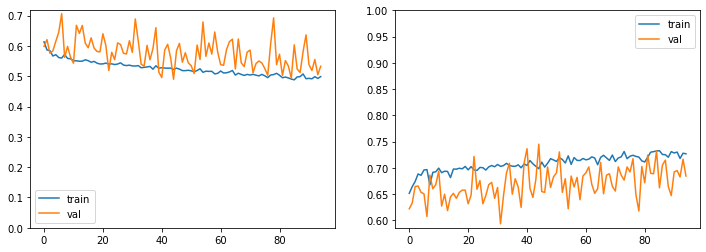

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5120 - accuracy: 0.8028 - precision: 0.9976 - recall: 0.8011 - f1: 0.8830 - specificity: 0.2207 - negative_predictive_value: 0.0363 - matthews_correlation_coefficient: 0.0759 - val_loss: 0.6400 - val_accuracy: 0.6687 - val_precision: 0.9988 - val_recall: 0.6750 - val_f1: 0.8020 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0275 - val_matthews_correlation_coefficient: 0.0636

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06358, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_24-03_20_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3449 - accuracy: 0.8258 - precision: 0.9985 - recall: 0.8266 - f1: 0.9025 - specificity: 0.2276 - negative_predictive_value: 0.0447 - matthews_correlation_coefficient: 0.0886 - val_loss: 0.2522 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2411 - accuracy: 0.8690 - precision: 0.9992 - recall: 0.8660 - f1: 0.9266 - specificity: 0.2621 - negative_predictive_value: 0.0714 - matthews_correlation_coefficient: 0.1249 - val_loss: 0.3788 - val_accuracy: 0.8239 - val_precision: 0.9990 - val_recall: 0.8278 - val_f1: 0.9038 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0524 - val_matthews_correlation_coefficient: 0.1010

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.12355
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2357 - accuracy: 0.8597 - precision: 0.9995 - recall: 0.8597 - f1: 0.9231 - specificity: 0.2759 - negative_predictive_value: 0.0669 - matthews_correlation_coefficient: 0.1231 - val_loss: 0.2819 - val_accuracy: 0.8777 - val_precision: 0.9990 - val_recall: 0.8807 - val_f1: 0.9353 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0732 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.14667
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1880 - accuracy: 0.8790 - precision: 1.0000 - recall: 0.8787 - f1: 0.9343 - specificity: 0.2828 - negative_predictive_value: 0.0814 - matthews_correlation_coefficient: 0.1402 - val_loss: 0.2032 - val_accuracy: 0.9072 - val_precision: 0.9971 - val_recall: 0.9113 - val_f1: 0.9517 - val_specificity: 0.2027 - val_negative_predictive_value: 0.0878 - val_matthews_correlation_coefficient: 0.1205

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.14667
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1917 - accuracy: 0.8872 - precision: 1.0000 - recall: 0.8870 - f1: 0.9391 - specificity: 0.2552 - negative_predictive_value: 0.0812 - matthews_correlation_coefficient: 0.1340 - val_loss: 0.2326 - val_accuracy: 0.9055 - val_precision: 0.9980 - val_recall: 0.9087 - val_f1: 0.9508 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.14667
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1868 - accuracy: 0.8926 - precision: 0.9997 - recall: 0.8925 - f1: 0.9423 - specificity: 0.2966 - negative_predictive_value: 0.0935 - matthews_correlation_coefficient: 0.1536 - val_loss: 0.2221 - val_accuracy: 0.8951 - val_precision: 0.9981 - val_recall: 0.8984 - val_f1: 0.9448 - val_specificity: 0.2297 - val_negative_predictive_value: 0.0803 - val_matthews_correlation_coefficient: 0.1245

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.14667
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2376 - accuracy: 0.8683 - precision: 0.9998 - recall: 0.8683 - f1: 0.9274 - specificity: 0.2690 - negative_predictive_value: 0.0790 - matthews_correlation_coefficient: 0.1320 - val_loss: 0.2754 - val_accuracy: 0.8890 - val_precision: 0.9990 - val_recall: 0.8917 - val_f1: 0.9417 - val_spe

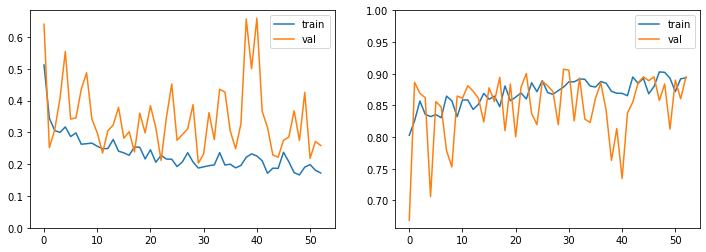

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_23-23_04_35.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_23-23_16_25.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_23-23_31_28.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_23-23_40_51.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_23-23_48_43.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_23-23_54_59.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_24-00_04_01.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_24-00_15_17.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_24-00_30_12.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_24-00_44_59.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_24-00_55_05.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_24-01_09_48.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_24-01_24_39.h5'


In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

list_files = glob('../data/pybossa/images/*')
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images\AR_FDB_m-006-16.png
1 of 1


[array([[0.9999831]], dtype=float32),
 array([[0.67980283]], dtype=float32),
 array([[0.91903937]], dtype=float32),
 array([[0.9726648]], dtype=float32),
 array([[0.9732789]], dtype=float32),
 array([[0.9923539]], dtype=float32),
 array([[0.9320689]], dtype=float32),
 array([[0.5033174]], dtype=float32),
 array([[0.5695263]], dtype=float32),
 array([[0.8605577]], dtype=float32),
 array([[0.85332006]], dtype=float32),
 array([[0.3086605]], dtype=float32),
 array([[0.9998766]], dtype=float32),
 array([[0.9404149]], dtype=float32),
 array([[0.8362865]], dtype=float32),
 array([[0.24946417]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.6494229]], dtype=float32),
 array([[0.9999169]], dtype=float32),
 array([[0.99884415]], dtype=float32),
 array([[0.44915184]], dtype=float32),
 array([[0.9999993]], dtype=float32)]